# HYDROCLIMATOLOGY PROJECT GROUP #1

# <span style="color:black; font-weight:bold;">  THIS SCRIPT WAS PREPARED BY 
---
## <span style="color:brown; font-weight:bold;"> 1. NANA OFOSUHENE PINK<span style="color:GREEN; font-weight:bold;">R<span style="color:brown; font-weight:bold;">AH
## <span style="color:red; font-weight:bold;"> 2. ADHIKARI SANSKA<span style="color:GREEN; font-weight:bold;">R<span style="color:red; font-weight:bold;">
## <span style="color:orange; font-weight:bold;"> 3. TOBBE PYPE<span style="color:GREEN; font-weight:bold;">R<span style="color:red; font-weight:bold;">
## <span style="color:blue; font-weight:bold;"> 4. HARRY WALTE<span style="color:GREEN; font-weight:bold;">R<span style="color:blue; font-weight:bold;">S

---------


# TOPIC: Extreme Precipitation Probability in Kentucky

##  Description
This script performs 1. Average Annual Maximum Precipitation (AMP) and 2. Extreme Value Analysis (EVA) using the **Gumbel distribution** to derive Intensity-Duration-Frequency (IDF) curves for a specified weather station. The resulting predicted IDF values are then rigorously validated against official intensity data sourced from **NOAA Atlas 14**.

The script generates three key visual outputs to summarize the analysis:
1.  **Predicted IDF Curves:** A single plot showing the calculated IDF curves for all analyzed return periods.
2.  **IDF Results Table:** An image file summarizing the final design intensities (in inches/hour) in a clear table format.
3.  **Validation Comparison Subplots:** A detailed comparison plot, breaking down the Predicted IDF vs. NOAA Atlas 14 for each return period into separate subplots.

## Station and Data
* **Station ID:** `FARM` (Currently analyzed station, configurable via `station_id_to_analyze`)
* **Data Source:** `annual_max_precip_2015_2024.csv` (Annual maximum precipitation data)
* **Analysis Period:** 2015-2024 (10 years)

## Methodology: Extreme Value Analysis (EVA)
1.  **Data Preparation:** Loads annual maximum precipitation values for the target station across all defined durations (5-min up to 24-hr).
2.  **Gumbel Distribution Fit:** For each duration, the annual maximum series is fitted to a Gumbel (Extreme Value Type I) distribution using the maximum likelihood estimation (`scipy.stats.gumbel_r.fit`).
3.  **Design Intensity Calculation:** The Intensity ($I$) for a given return period ($T$) and duration ($D$) is calculated using the Gumbel quantile function (PPF):
    $$I_T = \frac{P_T}{D} \times 60$$
    Where $P_T$ is the precipitation depth (inches) corresponding to the exceedance probability $F = 1 - 1/T$.

## Validation and Error Metrics
The primary objective of the comparison plot is validation:

* **Reference Data:** Hardcoded NOAA Atlas 14 intensity values are used as the ground truth.
* **Visual Comparison:** The comparison plot presents a side-by-side view (using subplots) of the Predicted IDF curve (solid line) and the NOAA Atlas 14 curve (dashed line) for each return period.
* **Goodness-of-Fit Metric:** The **Pearson Correlation Coefficient ($r$)** between the Predicted and Reference intensities is calculated and displayed in the title of each subplot.
    * **$r \approx 1$** indicates a strong linear relationship and excellent pattern agreement across all durations.

## Generated Outputs
The script saves three images in the current working directory:

| Filename Example | Content | Purpose |
| :--- | :--- | :--- |
| `FARM_final_idf_curve.png` | Log-log plot of all Gumbel IDF curves. | Initial visualization of predicted results. |
| `FARM_final_idf_results_table_v2.png` | Image of the numerical IDF table. | Clean, report-ready summary of design values. |
| `FARM_idf_validation_comparison_subplots_corr.png` | Subplots comparing Predicted vs. NOAA Atlas 14. | Detailed validation with correlation statistics. |

In [14]:
import pandas as pd
import os as os
import numpy as np

In [15]:
pwd

'/glade/u/home/npinkrah/hydroproject'

# Analyzing the structure and content of each CSV file to identify column names, data types.

In [3]:
import os
import pandas as pd
from pathlib import Path

# Specifying the directory containing your CSV files
data_dir = '/glade/u/home/npinkrah/hydroproject/PRECIP_DATA'

# Listing all CSV files in the directory
ds_data = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

if not ds_data:
    print("No CSV files found in the directory.")
else:
    print(f"Found {len(ds_data)} CSV files: {ds_data[:5]}...")
    for file in ds_data[:5]:
        file_path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(file_path, skiprows=1, nrows=10)
            
            print(f"\nFile: {file}")
            print("Columns after skiprows:", df.columns.tolist())
            print("Data Types:", df.dtypes)
            print("First 10 rows:\n", df)
            print("Date Range in Sample:", df['Timestamp'].min(), "to", df['Timestamp'].max()) 
            print("Missing Values per Column:\n", df.isnull().sum())
        except Exception as e:
            print(f"Error reading {file}: {e}")

Found 67 CSV files: ['FCHV.csv', 'SCTV.csv', 'PCWN.csv', 'LGRN.csv', 'CHTR.csv']...

File: FCHV.csv
Columns after skiprows: ['Station ID', 'Station County', 'Timestamp', 'Precipitation (inches)']
Data Types: Station ID                 object
Station County             object
Timestamp                  object
Precipitation (inches)    float64
dtype: object
First 10 rows:
   Station ID Station County            Timestamp  Precipitation (inches)
0       FCHV         Shelby  2010-12-02 11:30:00                     NaN
1       FCHV         Shelby  2010-12-02 11:35:00                     NaN
2       FCHV         Shelby  2010-12-02 11:40:00                     NaN
3       FCHV         Shelby  2010-12-02 11:45:00                     0.0
4       FCHV         Shelby  2010-12-02 11:50:00                     0.0
5       FCHV         Shelby  2010-12-02 11:55:00                     0.0
6       FCHV         Shelby  2010-12-02 12:00:00                     0.0
7       FCHV         Shelby  2010-12-02 12

# Goal: Load all CSV files, parse the Timestamp column, filter for 2015–2024, and combine into a single DataFrame.

In [4]:
import os
import pandas as pd
from pathlib import Path

data_dir = Path('/glade/u/home/npinkrah/hydroproject/PRECIP_DATA')
combined_data_path = data_dir.parent / 'combined_data_2015_2024.csv'

ds_data = [f for f in data_dir.iterdir() if f.suffix.lower() == '.csv']

if not ds_data:
    print("No CSV files found in the directory.")
else:
    print(f"Found {len(ds_data)} CSV files...")
    
    dfs = []
    for file_path in ds_data:
        file_name = file_path.name
        try:
            df = pd.read_csv(file_path, header=1, parse_dates=['Timestamp'])

            df = df[
                (df['Timestamp'].dt.year >= 2015) & 
                (df['Timestamp'].dt.year <= 2024)
            ]

            df.rename(columns={
                'Station County': 'county',
                'Timestamp': 'timestamp',
                'Precipitation (inches)': 'precip_in'
            }, inplace=True)
            df.drop(columns=['Station ID'], inplace=True, errors='ignore') 
            df['station_id'] = file_name.split('.')[0] 

            df = df[['station_id', 'county', 'timestamp', 'precip_in']]

            dfs.append(df)
            print(f"Loaded: {file_name} with {len(df)} rows (2015-2024)")
            
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        
        initial_rows = len(data)
        data.drop_duplicates(subset=['station_id', 'timestamp'], keep='first', inplace=True)
        final_rows = len(data)
        
        print(f"\n--- Data Processing Complete ---")
        print(f"Number of duplicate rows removed: {initial_rows - final_rows}")
        
        data.sort_values(['station_id', 'timestamp'], inplace=True)
        
        print("Head of Combined Data:")
        print(data.head())
        print(f"Total rows loaded (2015-2024): {len(data)}")

        data.to_csv(combined_data_path, index=False)
        print(f"Combined data saved to: {combined_data_path}")
    else:
        print("No DataFrames were successfully loaded.")

Found 67 CSV files...
Loaded: FCHV.csv with 2103604 rows (2015-2024)
Loaded: SCTV.csv with 2102966 rows (2015-2024)
Loaded: PCWN.csv with 2104026 rows (2015-2024)
Loaded: LGRN.csv with 2104042 rows (2015-2024)
Loaded: CHTR.csv with 2103972 rows (2015-2024)
Loaded: CADZ.csv with 2104014 rows (2015-2024)
Loaded: HCKM.csv with 2103966 rows (2015-2024)
Loaded: HRDB.csv with 2103982 rows (2015-2024)
Loaded: DORT.csv with 2103508 rows (2015-2024)
Loaded: WNCH.csv with 2099318 rows (2015-2024)
Loaded: DIXO.csv with 1257990 rows (2015-2024)
Loaded: BRND.csv with 2104060 rows (2015-2024)
Loaded: RPTN.csv with 2103910 rows (2015-2024)
Loaded: RSVL.csv with 2104064 rows (2015-2024)
Loaded: ELST.csv with 2103930 rows (2015-2024)
Loaded: WADD.csv with 1241842 rows (2015-2024)
Loaded: PSPG.csv with 718016 rows (2015-2024)
Loaded: ZION.csv with 2103852 rows (2015-2024)
Loaded: FRNY.csv with 2103888 rows (2015-2024)
Loaded: PRYB.csv with 2102984 rows (2015-2024)
Loaded: GRHM.csv with 2104020 rows (201

# STEP 1

In [5]:
#  Rolling Precipitation Sums

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

# Define paths and constants
combined_data_path = Path('/glade/u/home/npinkrah/hydroproject/combined_data_2015_2024.csv')
output_sums_path = Path('/glade/u/home/npinkrah/hydroproject/event_sums_2015_2024.csv')

# Durations in minutes
durations = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]

data = pd.read_csv(combined_data_path, parse_dates=['timestamp'])

non_zero_precip = data[data['precip_in'] > 0]
print(f"Total non-zero precipitation rows: {len(non_zero_precip)}")

def calculate_sliding_sums_corrected(group_df, all_durations):
    """Calculates all sliding sums for a single station group, including 'county'."""
    group_df = group_df.sort_values('timestamp').copy()
    
    for duration_min in all_durations:
        window_size = duration_min // 5
        
        group_df[f'sum_{duration_min}min'] = group_df['precip_in'].rolling(
            window=window_size, 
            min_periods=1
        ).sum()

    cols_to_return = ['station_id', 'county', 'timestamp', 'precip_in'] + [f'sum_{d}min' for d in all_durations]
    return group_df[cols_to_return]

unique_stations = data['station_id'].unique()
print(f"\nStarting calculations for {len(unique_stations)} unique stations...")

final_sums_list = []

for i, station_id in enumerate(unique_stations):
    station_data = data[data['station_id'] == station_id].copy()
    station_sums = calculate_sliding_sums_corrected(station_data, durations)
    final_sums_list.append(station_sums)
    
    print(f"Finished station {i+1}/{len(unique_stations)}: {station_id} ({len(station_data)} rows)")

event_sums = pd.concat(final_sums_list, ignore_index=True)

print(f"\nTotal rows after summation: {len(event_sums)}")
event_sums.to_csv(output_sums_path, index=False)
print(f"Final event sums data saved to: {output_sums_path}")

Total non-zero precipitation rows: 2651092

Starting calculations for 67 unique stations...
Finished station 1/67: ALBN (1051821 rows)
Finished station 2/67: BLRK (1051163 rows)
Finished station 3/67: BMBL (1051905 rows)
Finished station 4/67: BMTN (1024793 rows)
Finished station 5/67: BNGL (1051863 rows)
Finished station 6/67: BNVL (1049358 rows)
Finished station 7/67: BRND (1051910 rows)
Finished station 8/67: BTCK (1050996 rows)
Finished station 9/67: CADZ (1051887 rows)
Finished station 10/67: CCLA (1051842 rows)
Finished station 11/67: CCTY (1049777 rows)
Finished station 12/67: CHTR (1051866 rows)
Finished station 13/67: CMBA (1051893 rows)
Finished station 14/67: CRMT (1051883 rows)
Finished station 15/67: CRRL (1051834 rows)
Finished station 16/67: DIXO (628923 rows)
Finished station 17/67: DORT (1051634 rows)
Finished station 18/67: DRFN (1050570 rows)
Finished station 19/67: ELST (1051845 rows)
Finished station 20/67: ERLN (1051743 rows)
Finished station 21/67: FARM (1051534 

#### Grouping the data into years 

In [7]:
import pandas as pd
from pathlib import Path

output_sums_path = Path('/glade/u/home/npinkrah/hydroproject/event_sums_2015_2024.csv')
annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')

durations = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in durations]

#1. Loading the Data with Rolling Sums
try:
    event_sums = pd.read_csv(output_sums_path, parse_dates=['timestamp'])
except FileNotFoundError:
    print(f"Error: The required file was not found at {output_sums_path}. Cannot proceed.")
    exit()

print(f"Loaded event sums data with {len(event_sums)} records.")

# 2. Extracting Year and Calculate Annual Maximum Precipitation (AMP)

# Extract the year from the timestamp
event_sums['year'] = event_sums['timestamp'].dt.year

# Grouping by station_id and year, and calculate the MAXIMUM value for all duration columns
annual_max_precip = event_sums.groupby(['station_id', 'year'])[all_sum_cols].max().reset_index()

print("\nAnnual Maximum Precipitation (AMP) Table Head:")
print(annual_max_precip.head(10))

print("\nAMP Table Summary (Max values by duration across all years):")
print(annual_max_precip[all_sum_cols].max())

annual_max_precip.to_csv(annual_max_path, index=False)
print(f"\nAnnual Maximum Precipitation data saved to: {annual_max_path}")

Loaded event sums data with 67855797 records.

Annual Maximum Precipitation (AMP) Table Head:
  station_id  year  sum_5min  sum_10min  sum_15min  sum_30min  sum_60min  \
0       ALBN  2015  0.414173   0.637008   0.847638   1.171260   1.509843   
1       ALBN  2016  0.415355   0.770079   0.898819   1.415749   1.438190   
2       ALBN  2017  0.376378   0.746063   1.072442   1.325985   1.545670   
3       ALBN  2018  0.381496   0.528740   0.659449   0.912993   1.257481   
4       ALBN  2019  0.467323   0.914567   1.022048   1.157481   1.215355   
5       ALBN  2020  0.489370   0.577953   0.644489   0.830315   1.122835   
6       ALBN  2021  0.368110   0.685040   0.797245   1.151969   1.818111   
7       ALBN  2022  0.585433   0.905512   0.999607   1.170473   1.258268   
8       ALBN  2023  0.352756   0.543307   0.579134   0.768111   1.301182   
9       ALBN  2024  0.536221   0.779528   0.848819   0.922835   1.668111   

   sum_120min  sum_180min  sum_360min  sum_720min  sum_1440min  
0   

# plotting for just two stations 

Loaded Annual Maximum Precipitation data with 20 records.

Visualization saved as amp_distribution_box_plots.png


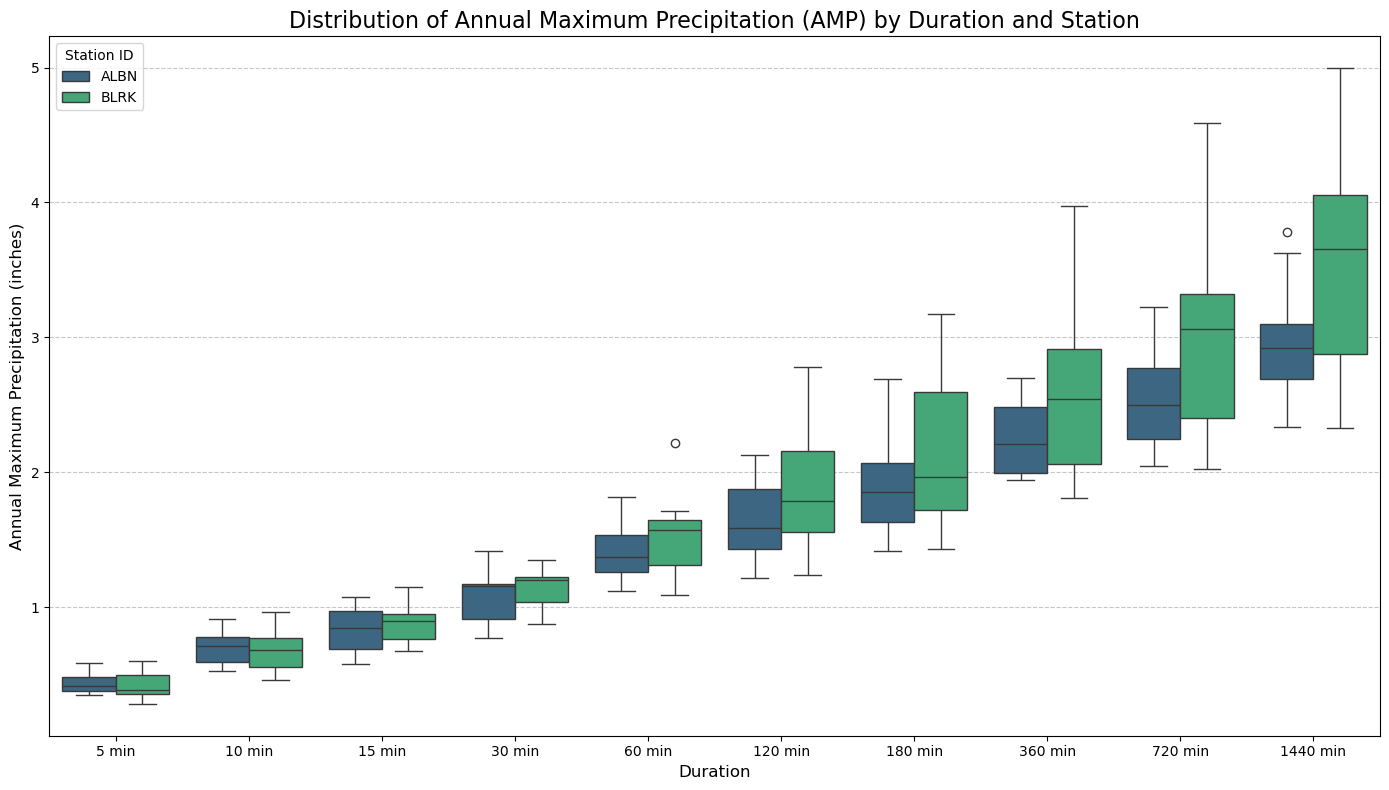

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')

durations = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in durations]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print(f"Error: The required file was not found at {annual_max_path}.")
    print("Please ensure the 'annual_max_precip_2015_2024.csv' file was generated successfully in the previous step.")
    exit()

print(f"Loaded Annual Maximum Precipitation data with {len(annual_max_precip)} records.")

plot_data = annual_max_precip.melt(
    id_vars=['station_id', 'year'],
    value_vars=all_sum_cols,
    var_name='Duration',
    value_name='Precipitation (inches)'
)

plot_data['Duration'] = plot_data['Duration'].str.replace('sum_', '').str.replace('min', ' min')
plt.figure(figsize=(14, 8))

sns.boxplot(
    data=plot_data, 
    x='Duration', 
    y='Precipitation (inches)', 
    hue='station_id',
    palette='viridis'
)

plt.title('Distribution of Annual Maximum Precipitation (AMP) by Duration and Station', fontsize=16)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Annual Maximum Precipitation (inches)', fontsize=12)
plt.legend(title='Station ID')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plot_filename = 'amp_distribution_box_plots.png'
plt.savefig(plot_filename)


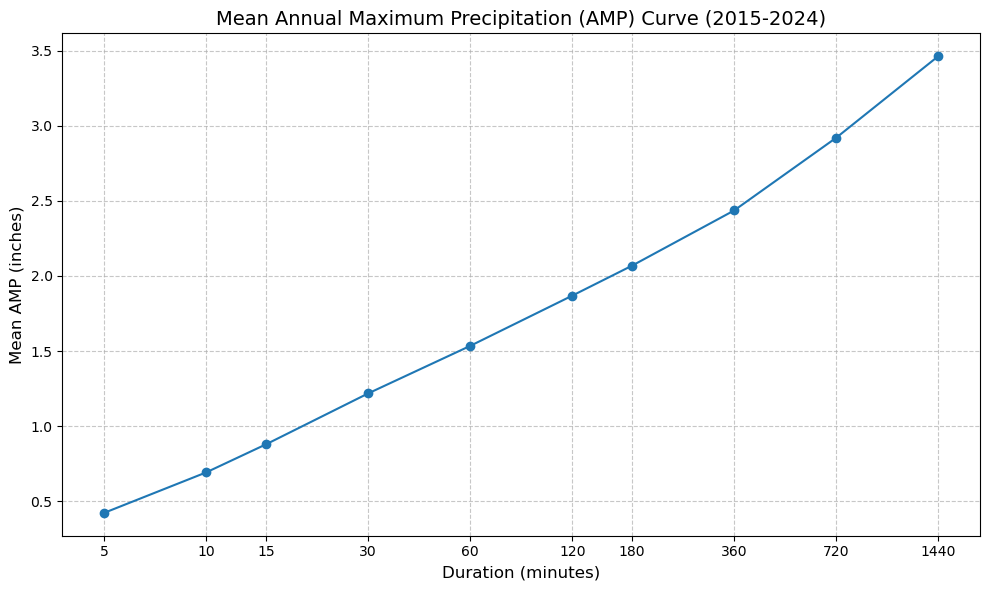

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
plot_filename = '2_mean_amp_curve.png'

durations = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in durations]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print("ERROR: File not found. Please check your absolute path.")

mean_amp = annual_max_precip[all_sum_cols].mean().reset_index()
mean_amp.columns = ['Duration_Col', 'Mean_AMP_Inches']

mean_amp['Duration_Min'] = mean_amp['Duration_Col'].str.replace('sum_', '').str.replace('min', '').astype(int)

plt.figure(figsize=(10, 6))
plt.plot(mean_amp['Duration_Min'], mean_amp['Mean_AMP_Inches'],
         marker='o', linestyle='-', color='tab:blue')

# logarithmic scale on the X-axis
plt.xscale('log') 

plt.title('Mean Annual Maximum Precipitation (AMP) Curve (2015-2024)', fontsize=14)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Mean AMP (inches)', fontsize=12)

plt.xticks(durations, [f'{d}' for d in durations])
plt.minorticks_off()

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(plot_filename,dpi=400)

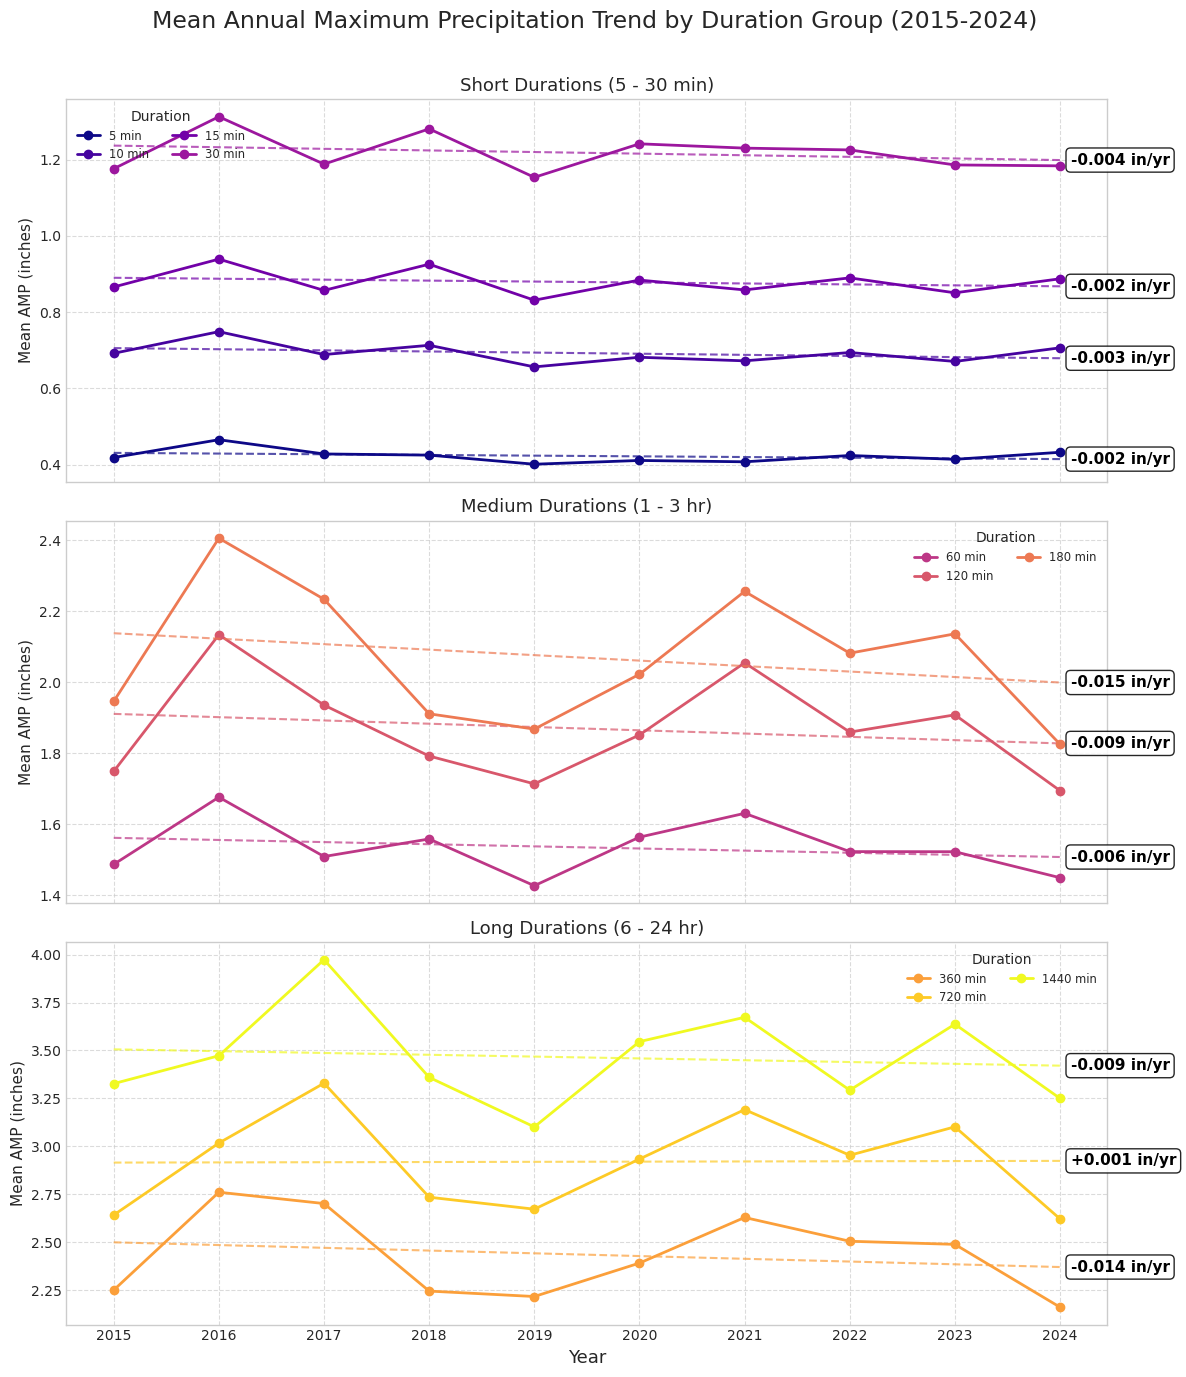

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
plot_filename = 'annual_max_time_series_subplots_READABLE.png'

durations = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in durations]

short_durations = ['5 min', '10 min', '15 min', '30 min']
medium_durations = ['60 min', '120 min', '180 min']
long_durations = ['360 min', '720 min', '1440 min']
duration_groups = [
    {'title': 'Short Durations (5 - 30 min)', 'durations': short_durations},
    {'title': 'Medium Durations (1 - 3 hr)', 'durations': medium_durations},
    {'title': 'Long Durations (6 - 24 hr)', 'durations': long_durations}
]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print(f"Error: The required file was not found at {annual_max_path}. Cannot proceed.")
    exit()


mean_annual_max_wide = annual_max_precip.groupby('year')[all_sum_cols].mean().reset_index()

plot_data = mean_annual_max_wide.melt(
    id_vars=['year'],
    value_vars=all_sum_cols,
    var_name='Duration_Col',
    value_name='Mean_AMP_Inches'
)
plot_data['Duration'] = plot_data['Duration_Col'].str.replace('sum_', '').str.replace('min', ' min')


plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True) 
fig.suptitle('Mean Annual Maximum Precipitation Trend by Duration Group (2015-2024)', fontsize=17, y=0.98) # Increased font size

all_durations_list = plot_data['Duration'].unique()
colors = plt.cm.plasma(np.linspace(0, 1, len(all_durations_list)))
color_map = {d: colors[i] for i, d in enumerate(all_durations_list)}

for ax, group in zip(axes, duration_groups):
    group_durations = group['durations']
    group_data = plot_data[plot_data['Duration'].isin(group_durations)]

    for duration in group_durations:
        duration_data = group_data[group_data['Duration'] == duration]
        
        X = duration_data['year']
        Y = duration_data['Mean_AMP_Inches']
        color = color_map[duration]
        
        coefficients = np.polyfit(X, Y, 1)
        slope = coefficients[0] 
        poly1d_fn = np.poly1d(coefficients)
        
        ax.plot(X, Y, 
                marker='o', linestyle='-', linewidth=2, 
                label=duration, color=color)

        ax.plot(X, poly1d_fn(X), 
                linestyle='--', linewidth=1.5, color=color, alpha=0.7)
                
        X_end = X.iloc[-1]
        Y_end = poly1d_fn(X_end)
        
        slope_label = f"{slope:+.3f} in/yr"
        
        ax.text(X_end + 0.1, Y_end, slope_label, 
                color='black',
                fontsize=11, 
                fontweight='bold',
                ha='left', 
                va='center', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.85, edgecolor='black'))

    ax.set_title(group['title'], fontsize=13) 
    ax.set_ylabel('Mean AMP (inches)', fontsize=11) 
    ax.legend(title='Duration', loc='best', ncol=2, fontsize='small')
    ax.grid(axis='both', linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Year', fontsize=13) 
axes[-1].set_xticks(mean_annual_max_wide['year'].tolist()) 

plt.tight_layout(rect=[0, 0, 1, 0.97]) 

plt.savefig(plot_filename, dpi=500)

In [ ]:
# spatial plot

DEBUG: Successfully merged data for 67 unique stations.
DEBUG: Global AMP Range for Colorbar (now using local scaling): [0.00, 11.28] inches.
Batch plot saved as spatial_amp_multiduration_avg_unified_cbar_part1.png
Batch plot saved as spatial_amp_multiduration_avg_unified_cbar_part2.png
Batch plot saved as spatial_amp_multiduration_avg_unified_cbar_part3.png


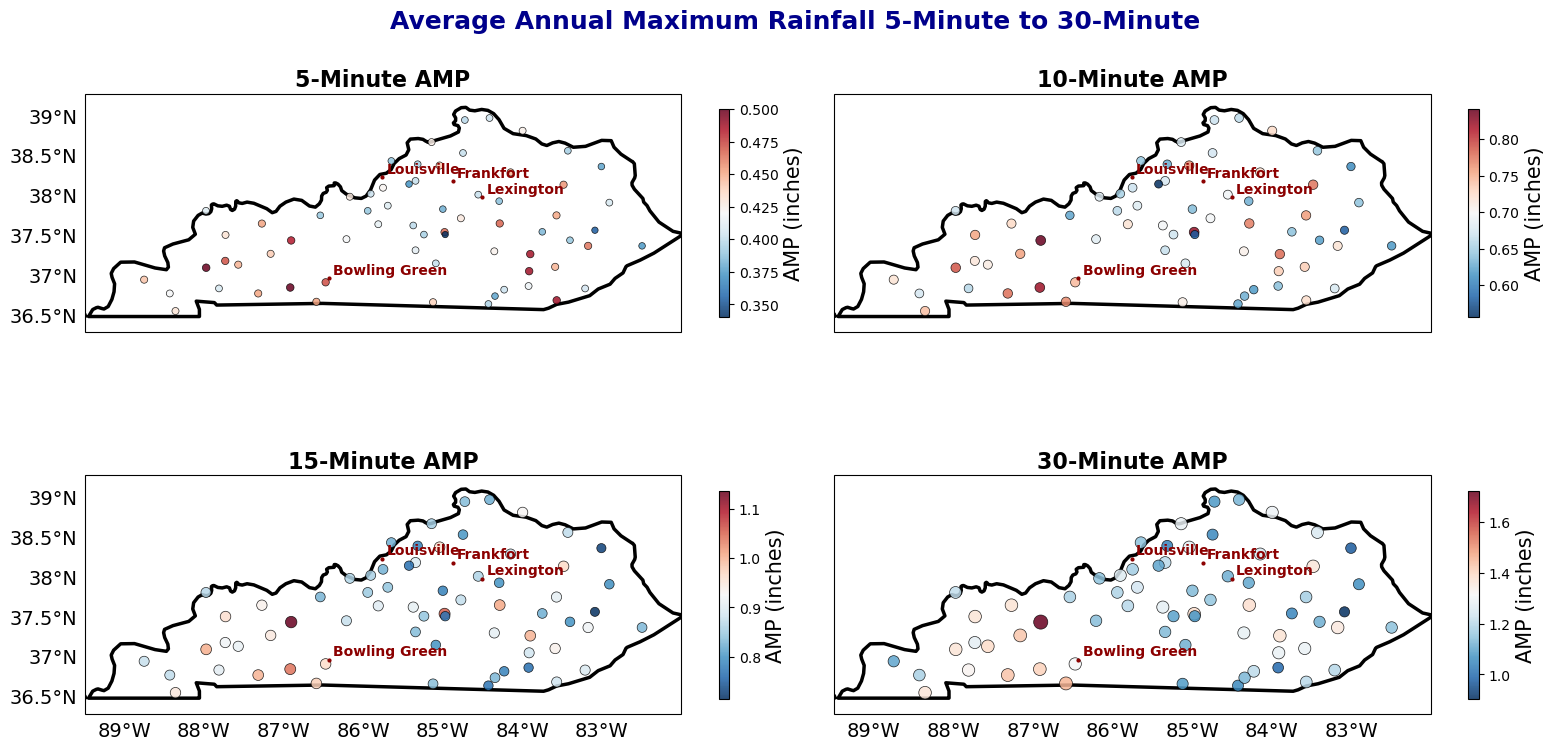

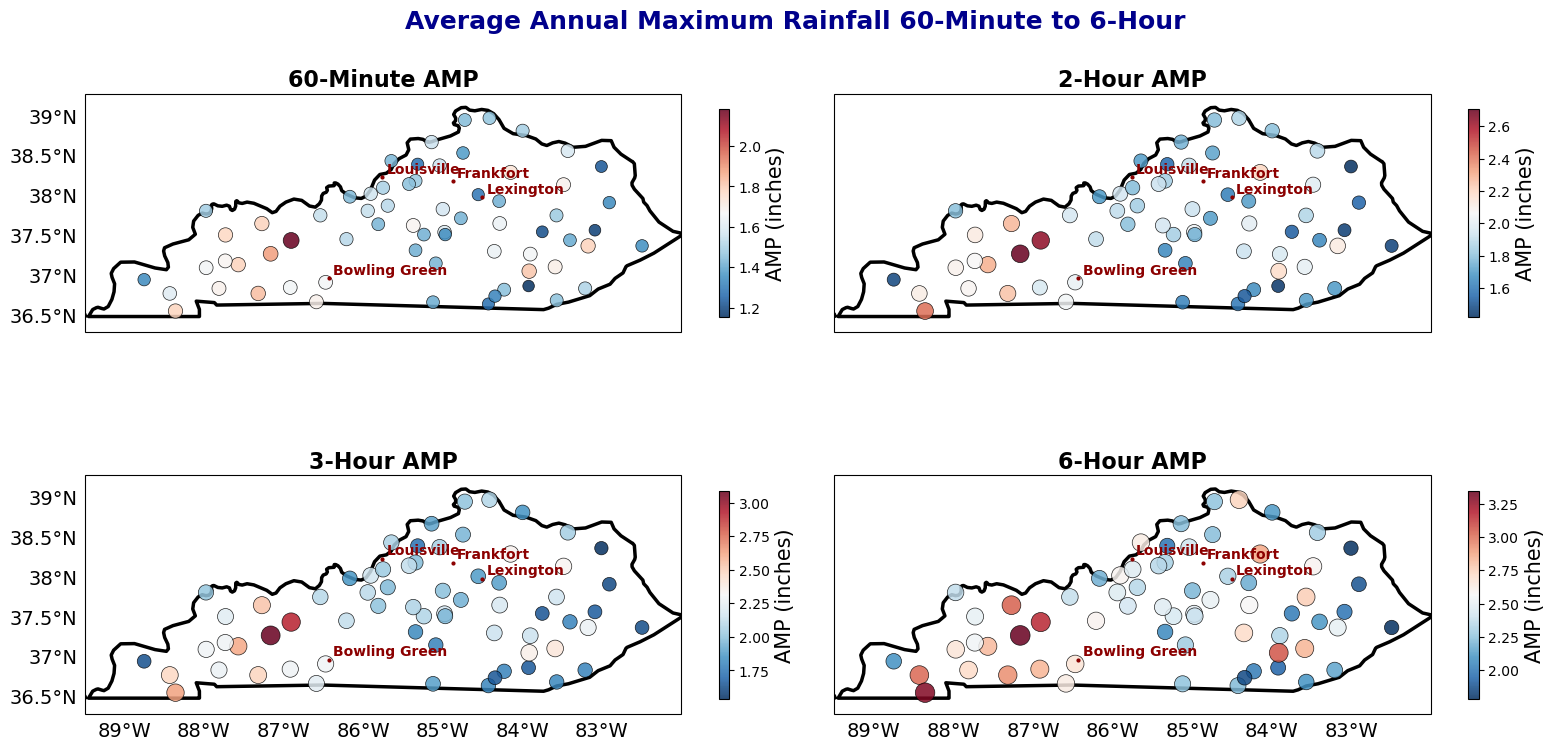

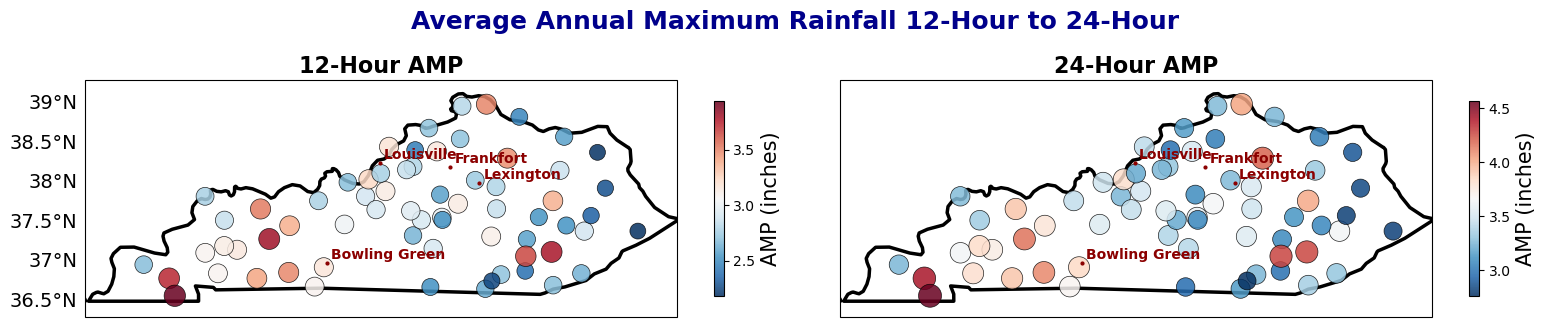

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader 

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')

plot_filename_base = 'spatial_amp_multiduration_avg_unified_cbar_part' 

DURATIONS = [
    ('sum_5min', '5-Minute'),
    ('sum_10min', '10-Minute'),
    ('sum_15min', '15-Minute'),
    ('sum_30min', '30-Minute'),
    ('sum_60min', '60-Minute'),
    ('sum_120min', '2-Hour'),
    ('sum_180min', '3-Hour'),
    ('sum_360min', '6-Hour'),
    ('sum_720min', '12-Hour'),
    ('sum_1440min', '24-Hour'),
]

#########
# KENTUCKY MESONET METADATA (67 Stations) 
# All 67 station IDs mapped to their correct geographic coordinates.

station_coords = {
    'FCHV': {'latitude': 38.2050, 'longitude': -85.3400},
    'SCTV': {'latitude': 37.3197, 'longitude': -84.3497},
    'PCWN': {'latitude': 37.7347, 'longitude': -84.7700},
    'LGRN': {'latitude': 38.4556, 'longitude': -85.6439},
    'CHTR': {'latitude': 38.5833, 'longitude': -83.4253},
    'CADZ': {'latitude': 36.8533, 'longitude': -87.8106},
    'HCKM': {'latitude': 38.3117, 'longitude': -84.1450},
    'HRDB': {'latitude': 36.9633, 'longitude': -88.7511},
    'DORT': {'latitude': 37.3881, 'longitude': -82.4925},
    'WNCH': {'latitude': 37.9500, 'longitude': -84.2886},
    'DIXO': {'latitude': 37.5256, 'longitude': -87.7283},
    'BRND': {'latitude': 38.0058, 'longitude': -86.1656},
    'RPTN': {'latitude': 37.1989, 'longitude': -87.7317},
    'RSVL': {'latitude': 36.8647, 'longitude': -86.9147},
    'ELST': {'latitude': 37.6697, 'longitude': -84.2817},
    'WADD': {'latitude': 38.1650, 'longitude': -85.4217},
    'PSPG': {'latitude': 37.7711, 'longitude': -83.5681},
    'ZION': {'latitude': 36.7900, 'longitude': -87.3175},
    'FRNY': {'latitude': 37.8286, 'longitude': -87.9739},
    'PRYB': {'latitude': 37.1242, 'longitude': -83.5850},
    'GRHM': {'latitude': 38.9700, 'longitude': -84.7200},
    'CCLA': {'latitude': 37.8286, 'longitude': -85.9406},
    'CRMT': {'latitude': 37.8933, 'longitude': -85.6886},
    'SWZR': {'latitude': 36.6850, 'longitude': -86.5861},
    'BTCK': {'latitude': 37.9317, 'longitude': -82.9039},
    'MROK': {'latitude': 37.0700, 'longitude': -83.9117},
    'BLRK': {'latitude': 37.4725, 'longitude': -86.2081},
    'WDBY': {'latitude': 36.8375, 'longitude': -84.2258},
    'CRRL': {'latitude': 38.6925, 'longitude': -85.1383},
    'MRHD': {'latitude': 38.1569, 'longitude': -83.4792},
    'BMBL': {'latitude': 36.8833, 'longitude': -83.9189},
    'SWON': {'latitude': 38.5556, 'longitude': -84.7433},
    'ERLN': {'latitude': 37.1517, 'longitude': -87.5683},
    'HUEY': {'latitude': 38.4144, 'longitude': -85.3128},
    'VEST': {'latitude': 37.5847, 'longitude': -83.0850},
    'LUSA': {'latitude': 38.3853, 'longitude': -83.0039},
    'HHTS': {'latitude': 37.8500, 'longitude': -84.9967},
    'LXGN': {'latitude': 38.0317, 'longitude': -84.5517},
    'MQDY': {'latitude': 37.5300, 'longitude': -84.9669},
    'LSML': {'latitude': 38.1189, 'longitude': -85.7486},
    'WTBG': {'latitude': 36.7567, 'longitude': -84.3411},
    'QKSD': {'latitude': 38.3978, 'longitude': -85.0372},
    'PRST': {'latitude': 37.3878, 'longitude': -83.1708},
    'PGHL': {'latitude': 38.9950, 'longitude': -84.4100},
    'BNGL': {'latitude': 37.3325, 'longitude': -85.3400},
    'PVRT': {'latitude': 37.6683, 'longitude': -87.2714},
    'FARM': {'latitude': 36.9300, 'longitude': -86.4700},
    'HTFD': {'latitude': 37.4561, 'longitude': -86.9033},
    'OLIN': {'latitude': 37.7719, 'longitude': -86.5369},
    'RNDH': {'latitude': 37.6444, 'longitude': -85.3686},
    'ALBN': {'latitude': 36.6800, 'longitude': -85.1200},
    'LGNT': {'latitude': 37.5300, 'longitude': -85.2344},
    'RBSN': {'latitude': 37.4589, 'longitude': -83.3986},
    'HDYV': {'latitude': 36.7033, 'longitude': -83.5656},
    'HDGV': {'latitude': 38.0433, 'longitude': -85.9033},
    'FLRK': {'latitude': 36.6575, 'longitude': -84.4239},
    'GRDR': {'latitude': 37.2847, 'longitude': -83.8978},
    'CMBA': {'latitude': 37.1683, 'longitude': -85.0850},
    'DRFN': {'latitude': 36.7900, 'longitude': -88.4289},
    'BNVL': {'latitude': 37.5647, 'longitude': -83.7469},
    'BMTN': {'latitude': 36.8525, 'longitude': -83.2081},
    'WLBT': {'latitude': 38.8350, 'longitude': -83.9939},
    'MRRY': {'latitude': 36.5689, 'longitude': -88.3572},
    'PRNC': {'latitude': 37.1133, 'longitude': -87.9717},
    'WSHT': {'latitude': 37.6600, 'longitude': -85.8083},
    'LRTO': {'latitude': 37.5606, 'longitude': -84.9750},
    'CCTY': {'latitude': 37.2883, 'longitude': -87.1611},
}

# Key city coordinates (Kentucky)
key_cities = {
    'Louisville': (38.25, -85.76),
    'Lexington': (38.00, -84.50),
    'Frankfort': (38.20, -84.87),
    'Bowling Green': (36.98, -86.43) 
}

station_metadata = pd.DataFrame([
    {'station_id': sid, **coords} 
    for sid, coords in station_coords.items()
])


try:
    annual_max_precip = pd.read_csv(annual_max_path)
    
    required_cols = ['station_id'] + [col for col, _ in DURATIONS]
    if not all(col in annual_max_precip.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in annual_max_precip.columns]
        print(f"Error: The precipitation file is missing one or more required duration columns: {missing_cols}. Cannot proceed with subplotting.")
        exit()

    merged_data = pd.merge(
        annual_max_precip, 
        station_metadata[['station_id', 'latitude', 'longitude']], 
        on='station_id', 
        how='inner'
    ).dropna(subset=['latitude', 'longitude'])

    if merged_data.empty:
        print("\nCRITICAL ERROR: The merge resulted in an empty dataset. Check station IDs.")
        exit()
    
    print(f"DEBUG: Successfully merged data for {merged_data['station_id'].nunique()} unique stations.")

except FileNotFoundError as e:
    print(f"Error: The required precipitation file was not found: {e.filename}. Cannot proceed.")
    exit()

all_duration_cols = [col for col, _ in DURATIONS]
numeric_cols = merged_data[all_duration_cols].select_dtypes(include=np.number).columns.tolist()
all_amp_data = merged_data[numeric_cols].values.flatten()
global_vmin = np.nanmin(all_amp_data)
global_vmax = np.nanmax(all_amp_data)
print(f"DEBUG: Global AMP Range for Colorbar (now using local scaling): [{global_vmin:.2f}, {global_vmax:.2f}] inches.")

plt.style.use('default') 
projection = ccrs.PlateCarree()

PLOTS_PER_FIGURE = 4
ROWS = 2
COLS = 2
NUM_DURATIONS = len(DURATIONS)
NUM_FIGURES = (NUM_DURATIONS + PLOTS_PER_FIGURE - 1) // PLOTS_PER_FIGURE 

min_lon, max_lon = -89.5, -82
min_lat, max_lat = 36.3, 39.3

cmap = plt.cm.RdBu_r 

try:
    states_shp = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_1_states_provinces_lakes')
    states_reader = shpreader.Reader(states_shp)
except Exception as e:
    print(f"Warning: Could not load state shapefiles for border filtering. Error: {e}")
    states_reader = None

for fig_idx in range(NUM_FIGURES):
    start_index = fig_idx * PLOTS_PER_FIGURE
    end_index = min((fig_idx + 1) * PLOTS_PER_FIGURE, NUM_DURATIONS)
    current_durations = DURATIONS[start_index:end_index]

    fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 10), subplot_kw={'projection': projection})
    axes = axes.flatten() 

    title_range = f'{current_durations[0][1]} to {current_durations[-1][1]}'
    fig.suptitle(f'Average Annual Maximum Rainfall {title_range}', 
                 fontsize=18, color='darkblue', fontweight='bold', y=0.86) 

    for plot_idx, (duration_col, duration_label) in enumerate(current_durations):
        ax = axes[plot_idx]

        spatial_mean_amp = merged_data.groupby(['station_id', 'latitude', 'longitude'])[duration_col].mean().reset_index()
        spatial_mean_amp = spatial_mean_amp.rename(columns={duration_col: 'Mean_AMP_Inches'})
        amp_values = spatial_mean_amp['Mean_AMP_Inches']

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

        ax.add_feature(cfeature.LAND, facecolor='white', alpha=1.0, zorder=0) 
        ax.add_feature(cfeature.OCEAN, facecolor='#e6f0ff', zorder=0) 
#        ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='#0077b6', linewidth=0.3, zorder=1)
#        ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='#00b4d8', alpha=0.5, zorder=1)
        
        if states_reader:
            try:
                kentucky_geom = None
                for state in states_reader.records():
                    if state.attributes.get('name') == 'Kentucky':
                        kentucky_geom = state.geometry
                        break
                
                if kentucky_geom:
                    ax.add_geometries(
                        [kentucky_geom], 
                        ccrs.PlateCarree(),
                        edgecolor='black', 
                        facecolor='none', 
                        linewidth=2.5, 
                        zorder=3
                    )
            except Exception as e:
                print(f"Error {e}. Falling back to no border.")
        
#        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.3, zorder=2)

        scatter = ax.scatter(
            spatial_mean_amp['longitude'],
            spatial_mean_amp['latitude'],
            c=amp_values,
            s=amp_values * 60, 
            cmap=cmap,
            alpha=0.85,
            edgecolor='black',
            linewidth=0.5,
            zorder=10, 
            transform=projection 
        )

        for city, (lat, lon) in key_cities.items():
            ax.plot(lon, lat, 'o', color='darkred', markersize=2, transform=projection, zorder=11)
            ax.annotate(city, (lon, lat), 
                        textcoords="offset points", xytext=(3,3), 
                        fontsize=10, color='darkred', fontweight='bold', 
                        transform=projection, zorder=11)

        ax.set_title(f'{duration_label} AMP', fontsize=16, fontweight='bold', pad=5) 

        gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        
        if plot_idx % COLS == 0: 
            gl.left_labels = True
        else:
            gl.left_labels = False
            
        if plot_idx >= ROWS:
            gl.bottom_labels = True
        else:
            gl.bottom_labels = False

        gl.xlabel_style = {'size': 14} 
        gl.ylabel_style = {'size': 14} 

        if scatter is not None:
            cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', 
                                shrink=0.4, pad=0.05, aspect=20) 
            cbar.set_label('AMP (inches)', fontsize=15) 


    for j in range(len(current_durations), PLOTS_PER_FIGURE):
        fig.delaxes(axes[j])
        
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.97]) 

    figure_plot_filename = f'{plot_filename_base}{fig_idx + 1}.png'
    plt.savefig(figure_plot_filename, dpi=500)
    print(f"Batch plot saved as {figure_plot_filename}")


DEBUG: Found 67 unique station IDs in the rainfall file.
DEBUG: First 5 IDs found are: ['ALBN', 'BLRK', 'BMBL', 'BMTN', 'BNGL']
DEBUG: Successfully merged data for 67 unique stations.


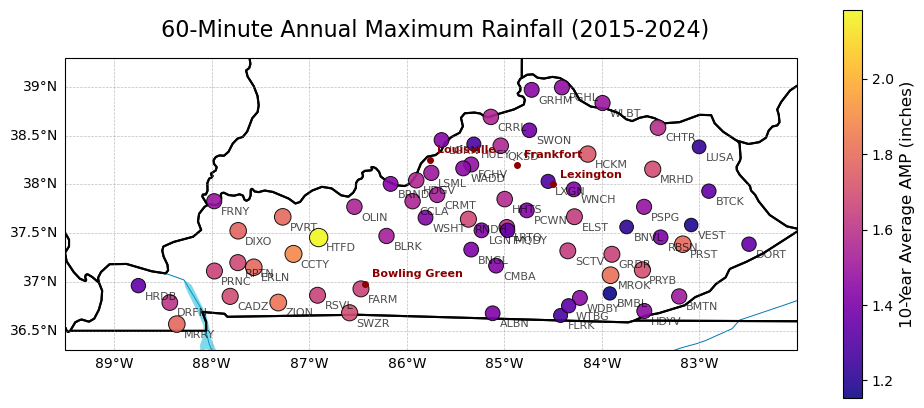

In [4]:

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')

plot_filename = 'spatial_amp_60min_avg.png'
TARGET_DURATION_COL = 'sum_60min'
TARGET_DURATION_LABEL = '60-Minute'

station_coords = {
    'FCHV': {'latitude': 38.2050, 'longitude': -85.3400},
    'SCTV': {'latitude': 37.3197, 'longitude': -84.3497},
    'PCWN': {'latitude': 37.7347, 'longitude': -84.7700},
    'LGRN': {'latitude': 38.4556, 'longitude': -85.6439},
    'CHTR': {'latitude': 38.5833, 'longitude': -83.4253},
    'CADZ': {'latitude': 36.8533, 'longitude': -87.8106},
    'HCKM': {'latitude': 38.3117, 'longitude': -84.1450},
    'HRDB': {'latitude': 36.9633, 'longitude': -88.7511},
    'DORT': {'latitude': 37.3881, 'longitude': -82.4925},
    'WNCH': {'latitude': 37.9500, 'longitude': -84.2886},
    'DIXO': {'latitude': 37.5256, 'longitude': -87.7283},
    'BRND': {'latitude': 38.0058, 'longitude': -86.1656},
    'RPTN': {'latitude': 37.1989, 'longitude': -87.7317},
    'RSVL': {'latitude': 36.8647, 'longitude': -86.9147},
    'ELST': {'latitude': 37.6697, 'longitude': -84.2817},
    'WADD': {'latitude': 38.1650, 'longitude': -85.4217},
    'PSPG': {'latitude': 37.7711, 'longitude': -83.5681},
    'ZION': {'latitude': 36.7900, 'longitude': -87.3175},
    'FRNY': {'latitude': 37.8286, 'longitude': -87.9739},
    'PRYB': {'latitude': 37.1242, 'longitude': -83.5850},
    'GRHM': {'latitude': 38.9700, 'longitude': -84.7200},
    'CCLA': {'latitude': 37.8286, 'longitude': -85.9406},
    'CRMT': {'latitude': 37.8933, 'longitude': -85.6886},
    'SWZR': {'latitude': 36.6850, 'longitude': -86.5861},
    'BTCK': {'latitude': 37.9317, 'longitude': -82.9039},
    'MROK': {'latitude': 37.0700, 'longitude': -83.9117},
    'BLRK': {'latitude': 37.4725, 'longitude': -86.2081},
    'WDBY': {'latitude': 36.8375, 'longitude': -84.2258},
    'CRRL': {'latitude': 38.6925, 'longitude': -85.1383},
    'MRHD': {'latitude': 38.1569, 'longitude': -83.4792},
    'BMBL': {'latitude': 36.8833, 'longitude': -83.9189},
    'SWON': {'latitude': 38.5556, 'longitude': -84.7433},
    'ERLN': {'latitude': 37.1517, 'longitude': -87.5683},
    'HUEY': {'latitude': 38.4144, 'longitude': -85.3128},
    'VEST': {'latitude': 37.5847, 'longitude': -83.0850},
    'LUSA': {'latitude': 38.3853, 'longitude': -83.0039},
    'HHTS': {'latitude': 37.8500, 'longitude': -84.9967},
    'LXGN': {'latitude': 38.0317, 'longitude': -84.5517},
    'MQDY': {'latitude': 37.5300, 'longitude': -84.9669},
    'LSML': {'latitude': 38.1189, 'longitude': -85.7486},
    'WTBG': {'latitude': 36.7567, 'longitude': -84.3411},
    'QKSD': {'latitude': 38.3978, 'longitude': -85.0372},
    'PRST': {'latitude': 37.3878, 'longitude': -83.1708},
    'PGHL': {'latitude': 38.9950, 'longitude': -84.4100},
    'BNGL': {'latitude': 37.3325, 'longitude': -85.3400},
    'PVRT': {'latitude': 37.6683, 'longitude': -87.2714},
    'FARM': {'latitude': 36.9300, 'longitude': -86.4700},
    'HTFD': {'latitude': 37.4561, 'longitude': -86.9033},
    'OLIN': {'latitude': 37.7719, 'longitude': -86.5369},
    'RNDH': {'latitude': 37.6444, 'longitude': -85.3686},
    'ALBN': {'latitude': 36.6800, 'longitude': -85.1200},
    'LGNT': {'latitude': 37.5300, 'longitude': -85.2344},
    'RBSN': {'latitude': 37.4589, 'longitude': -83.3986},
    'HDYV': {'latitude': 36.7033, 'longitude': -83.5656},
    'HDGV': {'latitude': 38.0433, 'longitude': -85.9033},
    'FLRK': {'latitude': 36.6575, 'longitude': -84.4239},
    'GRDR': {'latitude': 37.2847, 'longitude': -83.8978},
    'CMBA': {'latitude': 37.1683, 'longitude': -85.0850},
    'DRFN': {'latitude': 36.7900, 'longitude': -88.4289},
    'BNVL': {'latitude': 37.5647, 'longitude': -83.7469},
    'BMTN': {'latitude': 36.8525, 'longitude': -83.2081},
    'WLBT': {'latitude': 38.8350, 'longitude': -83.9939},
    'MRRY': {'latitude': 36.5689, 'longitude': -88.3572},
    'PRNC': {'latitude': 37.1133, 'longitude': -87.9717},
    'WSHT': {'latitude': 37.6600, 'longitude': -85.8083},
    'LRTO': {'latitude': 37.5606, 'longitude': -84.9750},
    'CCTY': {'latitude': 37.2883, 'longitude': -87.1611},
}

key_cities = {
    'Louisville': (38.25, -85.76),
    'Lexington': (38.00, -84.50),
    'Frankfort': (38.20, -84.87),
    'Bowling Green': (36.98, -86.43) # Near the FARM station
}

station_metadata_simulated = pd.DataFrame([
    {'station_id': sid, **coords} 
    for sid, coords in station_coords.items()
])

try:
    annual_max_precip = pd.read_csv(annual_max_path)

    precip_required_cols = ['station_id', TARGET_DURATION_COL]
    if not all(col in annual_max_precip.columns for col in precip_required_cols):
        print(f"Error: The precipitation file is missing one or more required columns ({precip_required_cols}).")
        print("Please ensure the precipitation data includes a column to identify the station.")
        exit()

    unique_ids = annual_max_precip['station_id'].unique()
    print(f"DEBUG: Found {len(unique_ids)} unique station IDs in the rainfall file.")
    print(f"DEBUG: First 5 IDs found are: {unique_ids[:5].tolist()}")

except FileNotFoundError as e:
    print(f"Error: The required precipitation file was not found: {e.filename}. Cannot proceed.")
    exit()

merged_data = pd.merge(
    annual_max_precip, 
    station_metadata_simulated[['station_id', 'latitude', 'longitude']], 
    on='station_id', 
    how='inner'
)

if merged_data.empty:
    print("\nCRITICAL ERROR: The merge resulted in an empty dataset.")
    exit()
else:
    print(f"DEBUG: Successfully merged data for {merged_data['station_id'].nunique()} unique stations.")

spatial_mean_amp = merged_data.groupby(['station_id', 'latitude', 'longitude'])[TARGET_DURATION_COL].mean().reset_index()
spatial_mean_amp = spatial_mean_amp.rename(columns={TARGET_DURATION_COL: 'Mean_AMP_Inches'})
spatial_mean_amp = spatial_mean_amp.dropna(subset=['latitude', 'longitude'])

plt.style.use('default') 
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

min_lon, max_lon = -89.5, -82
min_lat, max_lat = 36.3, 39.3

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

try:
    ax.add_feature(cfeature.LAND, facecolor='white', alpha=1.0, zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='#e6f0ff', zorder=0) 
    ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='#0077b6', linewidth=0.7, zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='#00b4d8', alpha=0.5, zorder=1)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=1.5, linestyle='-', zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=1.5, linestyle='-', zorder=2) 
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.5, zorder=2)

except Exception as e:
    print(f"\nWARNING: Could not load Cartopy map features. Plotting points only. Error: {e}")

amp_values = spatial_mean_amp['Mean_AMP_Inches']
norm = Normalize(vmin=amp_values.min(), vmax=amp_values.max())
cmap = plt.cm.plasma 

scatter = ax.scatter(
    spatial_mean_amp['longitude'],
    spatial_mean_amp['latitude'],
    c=amp_values,
    s=amp_values * 80, # Size factor
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolor='black',
    linewidth=0.7,
    zorder=10, 
    transform=projection 
)

for city, (lat, lon) in key_cities.items():
    ax.plot(lon, lat, 'o', color='darkred', markersize=4, transform=projection, zorder=11)
    ax.annotate(city, (lon, lat), 
                textcoords="offset points", xytext=(5,5), 
                fontsize=8, color='darkred', fontweight='bold', 
                transform=projection, zorder=11)


ax.set_title(f' {TARGET_DURATION_LABEL} Annual Maximum Rainfall (2015-2024)', fontsize=16, pad=15)

gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('10-Year Average AMP (inches)', fontsize=12)

for i, row in spatial_mean_amp.iterrows():
    ax.annotate(row['station_id'], (row['longitude'], row['latitude']), 
                textcoords="offset points", xytext=(5,-10), 
                fontsize=8, color='black', alpha=0.7, 
                transform=projection, zorder=10)

plt.tight_layout()

plt.savefig(plot_filename, dpi=300)

DEBUG: Successfully merged data for 67 unique stations.
DEBUG: Successfully loaded Kentucky geometry for masking.


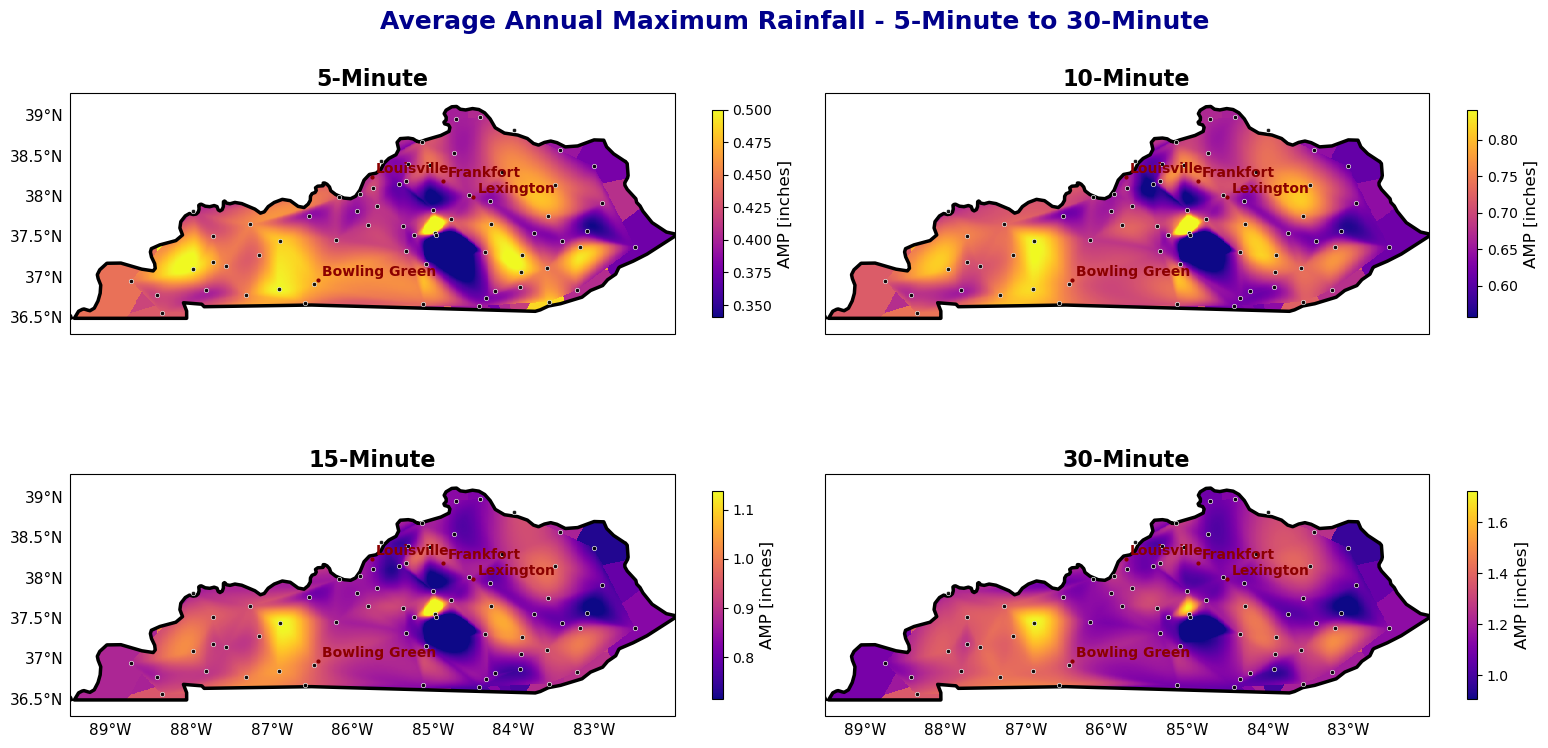

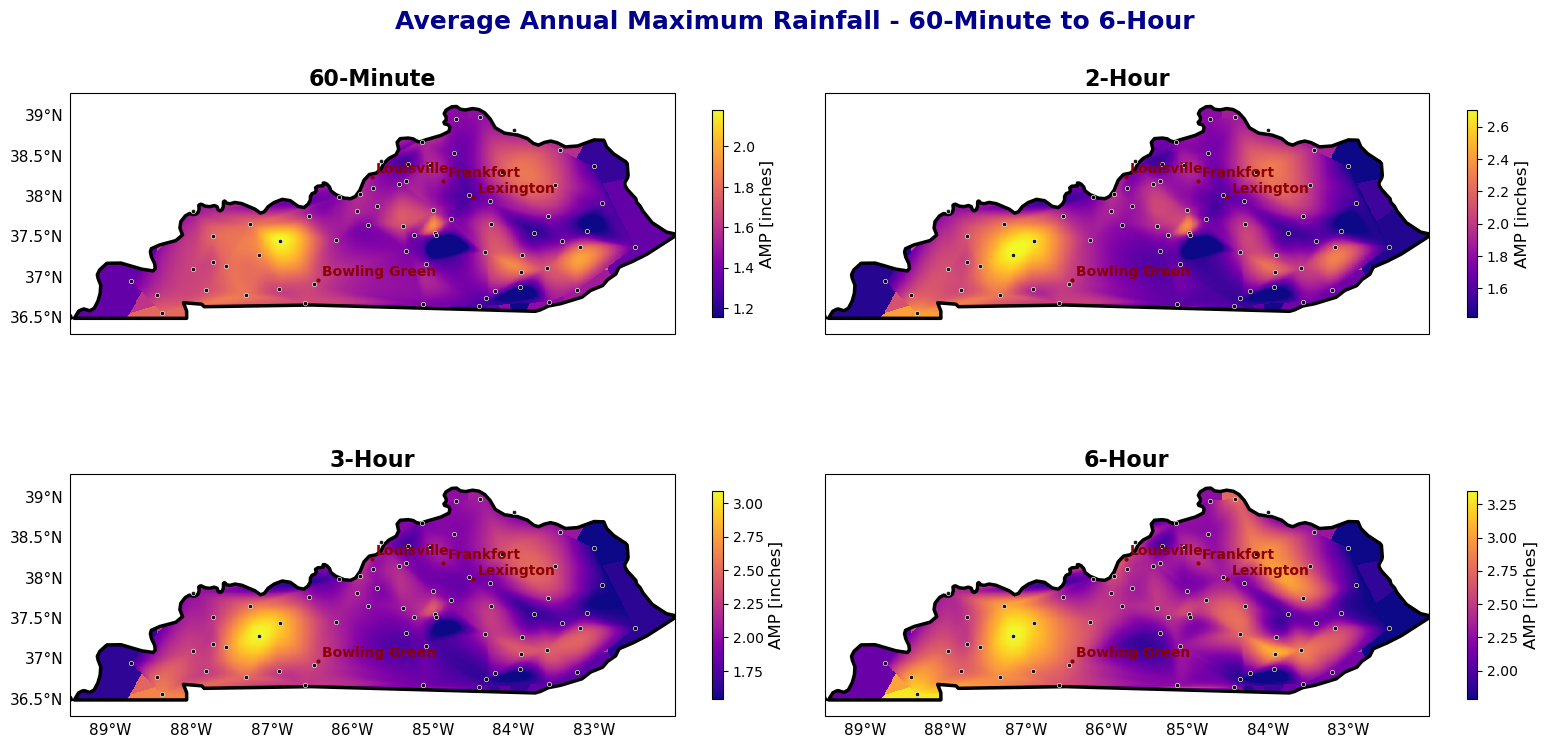

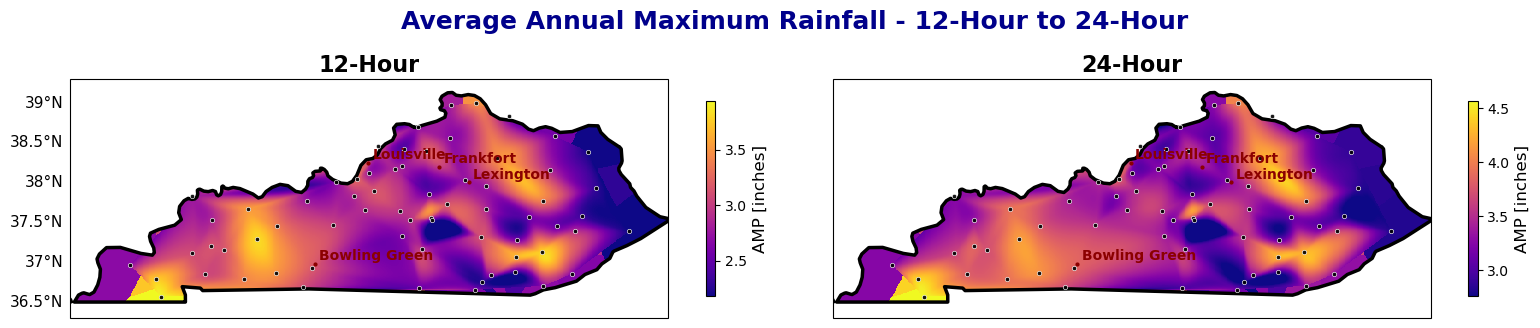

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from scipy.interpolate import griddata 
from matplotlib.path import Path as MplPath 

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
plot_filename_base = 'spatial_amp_multiduration_interpolated_continuous_part' 

DURATIONS = [
    ('sum_5min', '5-Minute'),
    ('sum_10min', '10-Minute'),
    ('sum_15min', '15-Minute'),
    ('sum_30min', '30-Minute'),
    ('sum_60min', '60-Minute'), 
    ('sum_120min', '2-Hour'),
    ('sum_180min', '3-Hour'),
    ('sum_360min', '6-Hour'),
    ('sum_720min', '12-Hour'),
    ('sum_1440min', '24-Hour'),
]

station_coords = {
    'FCHV': {'latitude': 38.2050, 'longitude': -85.3400},
    'SCTV': {'latitude': 37.3197, 'longitude': -84.3497},
    'PCWN': {'latitude': 37.7347, 'longitude': -84.7700},
    'LGRN': {'latitude': 38.4556, 'longitude': -85.6439},
    'CHTR': {'latitude': 38.5833, 'longitude': -83.4253},
    'CADZ': {'latitude': 36.8533, 'longitude': -87.8106},
    'HCKM': {'latitude': 38.3117, 'longitude': -84.1450},
    'HRDB': {'latitude': 36.9633, 'longitude': -88.7511},
    'DORT': {'latitude': 37.3881, 'longitude': -82.4925},
    'WNCH': {'latitude': 37.9500, 'longitude': -84.2886},
    'DIXO': {'latitude': 37.5256, 'longitude': -87.7283},
    'BRND': {'latitude': 38.0058, 'longitude': -86.1656},
    'RPTN': {'latitude': 37.1989, 'longitude': -87.7317},
    'RSVL': {'latitude': 36.8647, 'longitude': -86.9147},
    'ELST': {'latitude': 37.6697, 'longitude': -84.2817},
    'WADD': {'latitude': 38.1650, 'longitude': -85.4217},
    'PSPG': {'latitude': 37.7711, 'longitude': -83.5681},
    'ZION': {'latitude': 36.7900, 'longitude': -87.3175},
    'FRNY': {'latitude': 37.8286, 'longitude': -87.9739},
    'PRYB': {'latitude': 37.1242, 'longitude': -83.5850},
    'GRHM': {'latitude': 38.9700, 'longitude': -84.7200},
    'CCLA': {'latitude': 37.8286, 'longitude': -85.9406},
    'CRMT': {'latitude': 37.8933, 'longitude': -85.6886},
    'SWZR': {'latitude': 36.6850, 'longitude': -86.5861},
    'BTCK': {'latitude': 37.9317, 'longitude': -82.9039},
    'MROK': {'latitude': 37.0700, 'longitude': -83.9117},
    'BLRK': {'latitude': 37.4725, 'longitude': -86.2081},
    'WDBY': {'latitude': 36.8375, 'longitude': -84.2258},
    'CRRL': {'latitude': 38.6925, 'longitude': -85.1383},
    'MRHD': {'latitude': 38.1569, 'longitude': -83.4792},
    'BMBL': {'latitude': 36.8833, 'longitude': -83.9189},
    'SWON': {'latitude': 38.5556, 'longitude': -84.7433},
    'ERLN': {'latitude': 37.1517, 'longitude': -87.5683},
    'HUEY': {'latitude': 38.4144, 'longitude': -85.3128},
    'VEST': {'latitude': 37.5847, 'longitude': -83.0850},
    'LUSA': {'latitude': 38.3853, 'longitude': -83.0039},
    'HHTS': {'latitude': 37.8500, 'longitude': -84.9967},
    'LXGN': {'latitude': 38.0317, 'longitude': -84.5517},
    'MQDY': {'latitude': 37.5300, 'longitude': -84.9669},
    'LSML': {'latitude': 38.1189, 'longitude': -85.7486},
    'WTBG': {'latitude': 36.7567, 'longitude': -84.3411},
    'QKSD': {'latitude': 38.3978, 'longitude': -85.0372},
    'PRST': {'latitude': 37.3878, 'longitude': -83.1708},
    'PGHL': {'latitude': 38.9950, 'longitude': -84.4100},
    'BNGL': {'latitude': 37.3325, 'longitude': -85.3400},
    'PVRT': {'latitude': 37.6683, 'longitude': -87.2714},
    'FARM': {'latitude': 36.9300, 'longitude': -86.4700},
    'HTFD': {'latitude': 37.4561, 'longitude': -86.9033},
    'OLIN': {'latitude': 37.7719, 'longitude': -86.5369},
    'RNDH': {'latitude': 37.6444, 'longitude': -85.3686},
    'ALBN': {'latitude': 36.6800, 'longitude': -85.1200},
    'LGNT': {'latitude': 37.5300, 'longitude': -85.2344},
    'RBSN': {'latitude': 37.4589, 'longitude': -83.3986},
    'HDYV': {'latitude': 36.7033, 'longitude': -83.5656},
    'HDGV': {'latitude': 38.0433, 'longitude': -85.9033},
    'FLRK': {'latitude': 36.6575, 'longitude': -84.4239},
    'GRDR': {'latitude': 37.2847, 'longitude': -83.8978},
    'CMBA': {'latitude': 37.1683, 'longitude': -85.0850},
    'DRFN': {'latitude': 36.7900, 'longitude': -88.4289},
    'BNVL': {'latitude': 37.5647, 'longitude': -83.7469},
    'BMTN': {'latitude': 36.8525, 'longitude': -83.2081},
    'WLBT': {'latitude': 38.8350, 'longitude': -83.9939},
    'MRRY': {'latitude': 36.5689, 'longitude': -88.3572},
    'PRNC': {'latitude': 37.1133, 'longitude': -87.9717},
    'WSHT': {'latitude': 37.6600, 'longitude': -85.8083},
    'LRTO': {'latitude': 37.5606, 'longitude': -84.9750},
    'CCTY': {'latitude': 37.2883, 'longitude': -87.1611},
}

key_cities = {
    'Louisville': (38.25, -85.76),
    'Lexington': (38.00, -84.50),
    'Frankfort': (38.20, -84.87),
    'Bowling Green': (36.98, -86.43) 
}

station_metadata = pd.DataFrame([
    {'station_id': sid, **coords} 
    for sid, coords in station_coords.items()
])

try:
    annual_max_precip = pd.read_csv(annual_max_path)

    required_cols = ['station_id'] + [col for col, _ in DURATIONS]
    if not all(col in annual_max_precip.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in annual_max_precip.columns]
        print(f"Error: The precipitation file is missing one or more required duration columns: {missing_cols}. Cannot proceed with subplotting.")
        exit()

    merged_data = pd.merge(
        annual_max_precip, 
        station_metadata[['station_id', 'latitude', 'longitude']], 
        on='station_id', 
        how='inner'
    ).dropna(subset=['latitude', 'longitude'])

    if merged_data.empty:
        print("\nCRITICAL ERROR: The merge resulted in an empty dataset. Check station IDs.")
        exit()
    
    print(f"DEBUG: Successfully merged data for {merged_data['station_id'].nunique()} unique stations.")

except FileNotFoundError as e:
    print(f"Error: The required precipitation file was not found: {e.filename}. Cannot proceed.")
    exit()

min_lon, max_lon = -89.5, -82
min_lat, max_lat = 36.3, 39.3

GRID_RESOLUTION = 700 
lon_grid = np.linspace(min_lon, max_lon, GRID_RESOLUTION)
lat_grid = np.linspace(min_lat, max_lat, GRID_RESOLUTION)
xi, yi = np.meshgrid(lon_grid, lat_grid)

def get_all_exterior_coords(geometry):
    """Handles both Polygon and MultiPolygon to get all exterior boundary coords."""
    if geometry.geom_type == 'Polygon':
        return [np.asarray(geometry.exterior.coords)]
    elif geometry.geom_type == 'MultiPolygon':
        coords = []
        for poly in geometry.geoms:
            coords.append(np.asarray(poly.exterior.coords))
        return coords
    return []

kentucky_geom = None
exterior_coords_list = []
states_reader = None

try:
    states_shp = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_1_states_provinces_lakes')
    states_reader = shpreader.Reader(states_shp)
    
    for state in states_reader.records():
        if state.attributes.get('name') == 'Kentucky':
            kentucky_geom = state.geometry
            break
            
    if kentucky_geom:
        exterior_coords_list = get_all_exterior_coords(kentucky_geom)
        print("DEBUG: Successfully loaded Kentucky geometry for masking.")
    else:
        print("WARNING: 'Kentucky' geometry not found in shapefile data.")

except Exception as e:
    print(f"CRITICAL MASKING ERROR: Could not extract Kentucky geometry. Error: {e}. Masking will be skipped.")
    kentucky_geom = None

plt.style.use('default') 
projection = ccrs.PlateCarree()

PLOTS_PER_FIGURE = 4
ROWS = 2
COLS = 2
NUM_DURATIONS = len(DURATIONS)
NUM_FIGURES = (NUM_DURATIONS + PLOTS_PER_FIGURE - 1) // PLOTS_PER_FIGURE 

cmap = plt.cm.plasma 


for fig_idx in range(NUM_FIGURES):
    start_index = fig_idx * PLOTS_PER_FIGURE
    end_index = min((fig_idx + 1) * PLOTS_PER_FIGURE, NUM_DURATIONS)
    current_durations = DURATIONS[start_index:end_index]

    fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 10), subplot_kw={'projection': projection})
    axes = axes.flatten() 

    title_range = f'{current_durations[0][1]} to {current_durations[-1][1]}'
    fig.suptitle(f'Average Annual Maximum Rainfall - {title_range}', 
                 fontsize=18, color='darkblue', fontweight='bold', y=0.86) 

    for plot_idx, (duration_col, duration_label) in enumerate(current_durations):
        ax = axes[plot_idx]

        spatial_mean_amp = merged_data.groupby(['station_id', 'latitude', 'longitude'])[duration_col].mean().reset_index()
        spatial_mean_amp = spatial_mean_amp.rename(columns={duration_col: 'Mean_AMP_Inches'})

        points = spatial_mean_amp[['longitude', 'latitude']].values
        values = spatial_mean_amp['Mean_AMP_Inches'].values

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

        interpolated_data = griddata(points, values, (xi, yi), method='cubic')

        nan_mask = np.isnan(interpolated_data)
        if np.any(nan_mask):
             interpolated_data[nan_mask] = griddata(
                 points, 
                 values, 
                 (xi[nan_mask], yi[nan_mask]), 
                 method='nearest'
             )

        if kentucky_geom:
            try:
                grid_points = np.vstack((xi.flatten(), yi.flatten())).T

                final_mask = np.zeros(grid_points.shape[0], dtype=bool)
                
                for coords in exterior_coords_list:
                    path = MplPath(coords)
                    final_mask = final_mask | path.contains_points(grid_points)

                mask_2d = final_mask.reshape(xi.shape)

                interpolated_data[~mask_2d] = np.nan

                ax.add_geometries(
                    [kentucky_geom], 
                    ccrs.PlateCarree(),
                    edgecolor='black', 
                    facecolor='none', 
                    linewidth=2.5, 
                    zorder=8 
                )
            except Exception as e:
                print(f"Error applying mask or drawing border: {e}. Plotting unmasked data.")
        
        vmin_local = np.nanmin(values)
        vmax_local = np.nanmax(values)
        
        plot = ax.pcolormesh(
            lon_grid,
            lat_grid,
            interpolated_data,
            cmap=cmap,
            vmin=vmin_local,
            vmax=vmax_local,
            transform=projection,
            shading='auto', 
            zorder=5 
        )

        ax.add_feature(cfeature.LAND, facecolor='white', alpha=1.0, zorder=0) 
        ax.add_feature(cfeature.OCEAN, facecolor='#e6f0ff', zorder=0) 
 #       ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='#0077b6', linewidth=0.3, zorder=1)
  #      ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='#00b4d8', alpha=0.5, zorder=1)
#        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.3, zorder=2)


        ax.scatter(
            spatial_mean_amp['longitude'],
            spatial_mean_amp['latitude'],
            c='black', 
            s=10,
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            zorder=10, 
            transform=projection 
        )

        for city, (lat, lon) in key_cities.items():
            ax.plot(lon, lat, 'o', color='darkred', markersize=2, transform=projection, zorder=11)
            ax.annotate(city, (lon, lat), 
                        textcoords="offset points", xytext=(3,3), 
                        fontsize=10, color='darkred', fontweight='bold', 
                        transform=projection, zorder=11)

        ax.set_title(f'{duration_label}', fontsize=16, fontweight='bold', pad=5) 

        gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        
        if plot_idx % COLS == 0: 
            gl.left_labels = True
        else:
            gl.left_labels = False
            
        if plot_idx >= ROWS: 
            gl.bottom_labels = True
        else:
            gl.bottom_labels = False

        gl.xlabel_style = {'size': 11} 
        gl.ylabel_style = {'size': 11} 

        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', 
                            shrink=0.4, pad=0.05, aspect=20) 
        cbar.set_label('AMP [inches]', fontsize=12) 


    for j in range(len(current_durations), PLOTS_PER_FIGURE):
        fig.delaxes(axes[j])
        
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.97]) 

    figure_plot_filename = f'{plot_filename_base}{fig_idx + 1}.png'
    plt.savefig(figure_plot_filename, dpi=500)

# Applying Kriging method

DEBUG: Successfully merged data for 67 unique stations.
DEBUG: Successfully loaded Kentucky geometry for masking.
Batch plot saved as spatial_kriging1.png
Batch plot saved as spatial_kriging2.png
Batch plot saved as spatial_kriging3.png
 Kriging done


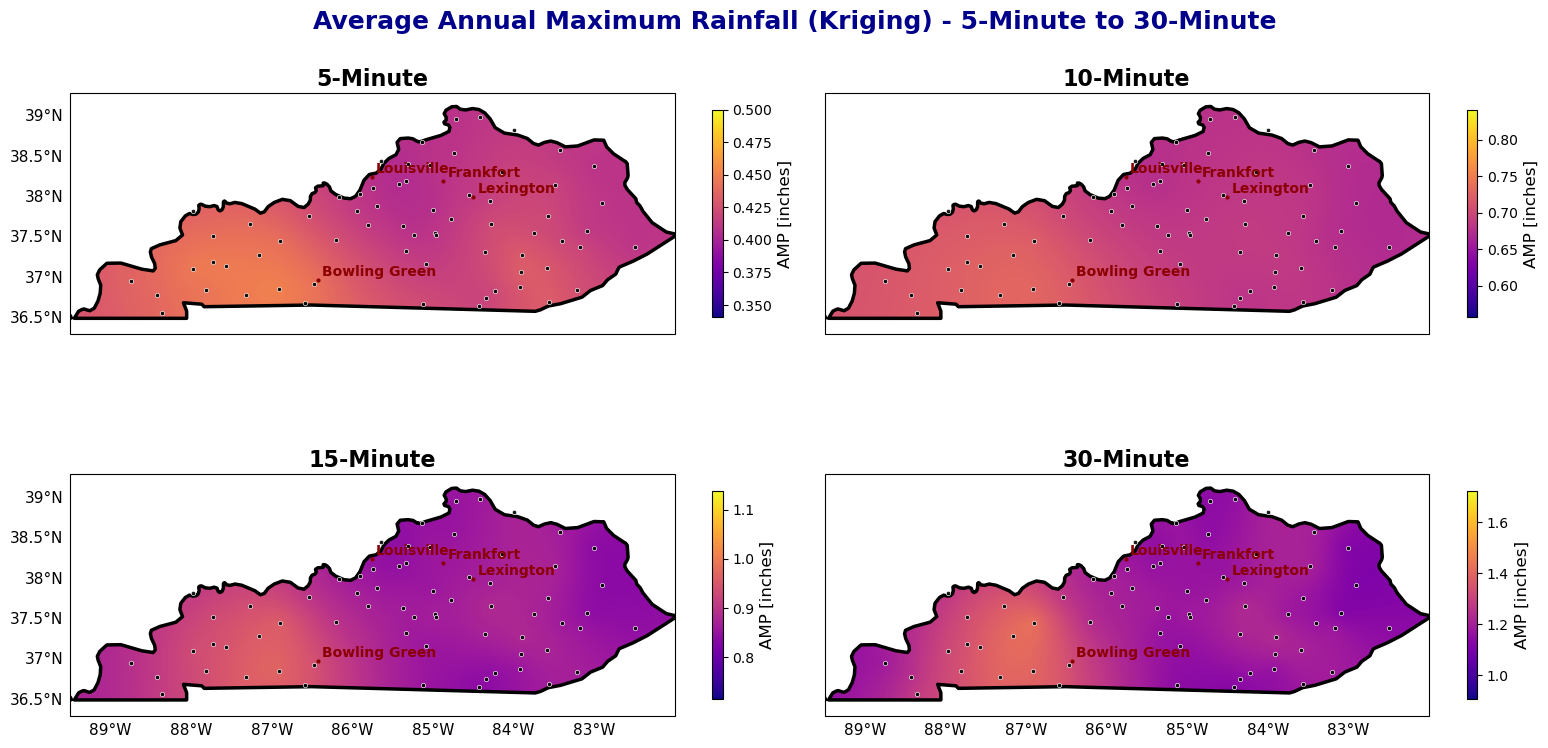

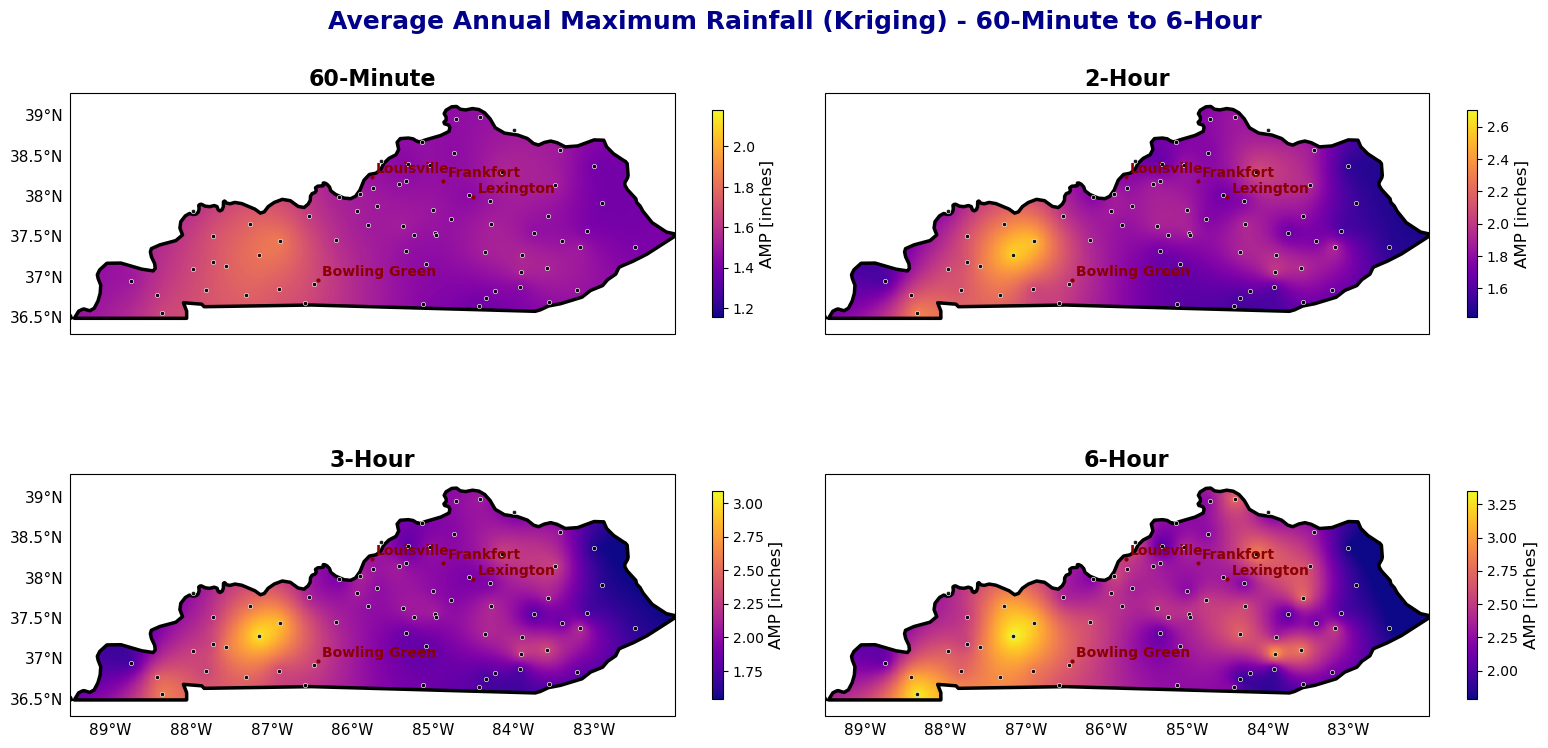

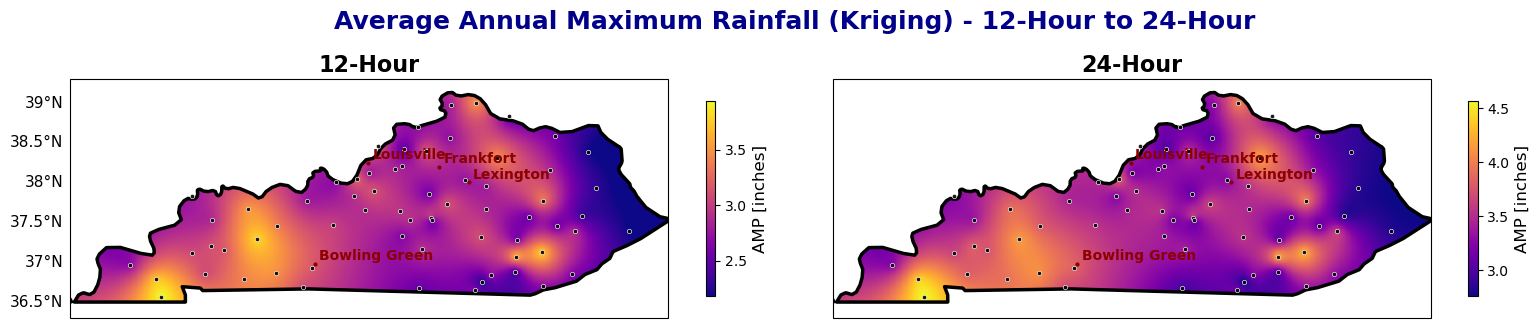

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
 
from pykrige.ok import OrdinaryKriging
from matplotlib.path import Path as MplPath

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
plot_filename_base = 'spatial_kriging'

DURATIONS = [
    ('sum_5min', '5-Minute'),
    ('sum_10min', '10-Minute'),
    ('sum_15min', '15-Minute'),
    ('sum_30min', '30-Minute'),
    ('sum_60min', '60-Minute'), 
    ('sum_120min', '2-Hour'),
    ('sum_180min', '3-Hour'),
    ('sum_360min', '6-Hour'),
    ('sum_720min', '12-Hour'),
    ('sum_1440min', '24-Hour'),
]

station_coords = {
    'FCHV': {'latitude': 38.2050, 'longitude': -85.3400},
    'SCTV': {'latitude': 37.3197, 'longitude': -84.3497},
    'PCWN': {'latitude': 37.7347, 'longitude': -84.7700},
    'LGRN': {'latitude': 38.4556, 'longitude': -85.6439},
    'CHTR': {'latitude': 38.5833, 'longitude': -83.4253},
    'CADZ': {'latitude': 36.8533, 'longitude': -87.8106},
    'HCKM': {'latitude': 38.3117, 'longitude': -84.1450},
    'HRDB': {'latitude': 36.9633, 'longitude': -88.7511},
    'DORT': {'latitude': 37.3881, 'longitude': -82.4925},
    'WNCH': {'latitude': 37.9500, 'longitude': -84.2886},
    'DIXO': {'latitude': 37.5256, 'longitude': -87.7283},
    'BRND': {'latitude': 38.0058, 'longitude': -86.1656},
    'RPTN': {'latitude': 37.1989, 'longitude': -87.7317},
    'RSVL': {'latitude': 36.8647, 'longitude': -86.9147},
    'ELST': {'latitude': 37.6697, 'longitude': -84.2817},
    'WADD': {'latitude': 38.1650, 'longitude': -85.4217},
    'PSPG': {'latitude': 37.7711, 'longitude': -83.5681},
    'ZION': {'latitude': 36.7900, 'longitude': -87.3175},
    'FRNY': {'latitude': 37.8286, 'longitude': -87.9739},
    'PRYB': {'latitude': 37.1242, 'longitude': -83.5850},
    'GRHM': {'latitude': 38.9700, 'longitude': -84.7200},
    'CCLA': {'latitude': 37.8286, 'longitude': -85.9406},
    'CRMT': {'latitude': 37.8933, 'longitude': -85.6886},
    'SWZR': {'latitude': 36.6850, 'longitude': -86.5861},
    'BTCK': {'latitude': 37.9317, 'longitude': -82.9039},
    'MROK': {'latitude': 37.0700, 'longitude': -83.9117},
    'BLRK': {'latitude': 37.4725, 'longitude': -86.2081},
    'WDBY': {'latitude': 36.8375, 'longitude': -84.2258},
    'CRRL': {'latitude': 38.6925, 'longitude': -85.1383},
    'MRHD': {'latitude': 38.1569, 'longitude': -83.4792},
    'BMBL': {'latitude': 36.8833, 'longitude': -83.9189},
    'SWON': {'latitude': 38.5556, 'longitude': -84.7433},
    'ERLN': {'latitude': 37.1517, 'longitude': -87.5683},
    'HUEY': {'latitude': 38.4144, 'longitude': -85.3128},
    'VEST': {'latitude': 37.5847, 'longitude': -83.0850},
    'LUSA': {'latitude': 38.3853, 'longitude': -83.0039},
    'HHTS': {'latitude': 37.8500, 'longitude': -84.9967},
    'LXGN': {'latitude': 38.0317, 'longitude': -84.5517},
    'MQDY': {'latitude': 37.5300, 'longitude': -84.9669},
    'LSML': {'latitude': 38.1189, 'longitude': -85.7486},
    'WTBG': {'latitude': 36.7567, 'longitude': -84.3411},
    'QKSD': {'latitude': 38.3978, 'longitude': -85.0372},
    'PRST': {'latitude': 37.3878, 'longitude': -83.1708},
    'PGHL': {'latitude': 38.9950, 'longitude': -84.4100},
    'BNGL': {'latitude': 37.3325, 'longitude': -85.3400},
    'PVRT': {'latitude': 37.6683, 'longitude': -87.2714},
    'FARM': {'latitude': 36.9300, 'longitude': -86.4700},
    'HTFD': {'latitude': 37.4561, 'longitude': -86.9033},
    'OLIN': {'latitude': 37.7719, 'longitude': -86.5369},
    'RNDH': {'latitude': 37.6444, 'longitude': -85.3686},
    'ALBN': {'latitude': 36.6800, 'longitude': -85.1200},
    'LGNT': {'latitude': 37.5300, 'longitude': -85.2344},
    'RBSN': {'latitude': 37.4589, 'longitude': -83.3986},
    'HDYV': {'latitude': 36.7033, 'longitude': -83.5656},
    'HDGV': {'latitude': 38.0433, 'longitude': -85.9033},
    'FLRK': {'latitude': 36.6575, 'longitude': -84.4239},
    'GRDR': {'latitude': 37.2847, 'longitude': -83.8978},
    'CMBA': {'latitude': 37.1683, 'longitude': -85.0850},
    'DRFN': {'latitude': 36.7900, 'longitude': -88.4289},
    'BNVL': {'latitude': 37.5647, 'longitude': -83.7469},
    'BMTN': {'latitude': 36.8525, 'longitude': -83.2081},
    'WLBT': {'latitude': 38.8350, 'longitude': -83.9939},
    'MRRY': {'latitude': 36.5689, 'longitude': -88.3572},
    'PRNC': {'latitude': 37.1133, 'longitude': -87.9717},
    'WSHT': {'latitude': 37.6600, 'longitude': -85.8083},
    'LRTO': {'latitude': 37.5606, 'longitude': -84.9750},
    'CCTY': {'latitude': 37.2883, 'longitude': -87.1611},
}

key_cities = {
    'Louisville': (38.25, -85.76),
    'Lexington': (38.00, -84.50),
    'Frankfort': (38.20, -84.87),
    'Bowling Green': (36.98, -86.43) 
}

station_metadata = pd.DataFrame([
    {'station_id': sid, **coords} 
    for sid, coords in station_coords.items()
])

try:
    annual_max_precip = pd.read_csv(annual_max_path)

    required_cols = ['station_id'] + [col for col, _ in DURATIONS]
    if not all(col in annual_max_precip.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in annual_max_precip.columns]
        print(f"Error: The precipitation file is missing one or more required duration columns: {missing_cols}. Cannot proceed with subplotting.")
        exit()

    merged_data = pd.merge(
        annual_max_precip, 
        station_metadata[['station_id', 'latitude', 'longitude']], 
        on='station_id', 
        how='inner'
    ).dropna(subset=['latitude', 'longitude'])

    if merged_data.empty:
        print("\nCRITICAL ERROR: The merge resulted in an empty dataset. Check station IDs.")
        exit()
    
    print(f"DEBUG: Successfully merged data for {merged_data['station_id'].nunique()} unique stations.")

except FileNotFoundError as e:
    print(f"Error: The required precipitation file was not found: {e.filename}. Cannot proceed.")
    exit()

min_lon, max_lon = -89.5, -82
min_lat, max_lat = 36.3, 39.3

GRID_RESOLUTION = 700 
lon_grid = np.linspace(min_lon, max_lon, GRID_RESOLUTION)
lat_grid = np.linspace(min_lat, max_lat, GRID_RESOLUTION)
xi, yi = np.meshgrid(lon_grid, lat_grid)

def get_all_exterior_coords(geometry):
    """Handles both Polygon and MultiPolygon to get all exterior boundary coords."""
    if geometry.geom_type == 'Polygon':
        return [np.asarray(geometry.exterior.coords)]
    elif geometry.geom_type == 'MultiPolygon':
        coords = []
        for poly in geometry.geoms:
            coords.append(np.asarray(poly.exterior.coords))
        return coords
    return []

kentucky_geom = None
exterior_coords_list = []
states_reader = None

try:
    states_shp = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_1_states_provinces_lakes')
    states_reader = shpreader.Reader(states_shp)
    
    for state in states_reader.records():
        if state.attributes.get('name') == 'Kentucky':
            kentucky_geom = state.geometry
            break
    if kentucky_geom:
        exterior_coords_list = get_all_exterior_coords(kentucky_geom)
        print("DEBUG: Successfully loaded Kentucky geometry for masking.")
    else:
        print("WARNING: 'Kentucky' geometry not found in shapefile data.")

except Exception as e:
    print(f"CRITICAL MASKING ERROR: Could not extract Kentucky geometry. Error: {e}. Masking will be skipped.")
    kentucky_geom = None

plt.style.use('default') 
projection = ccrs.PlateCarree()

PLOTS_PER_FIGURE = 4
ROWS = 2
COLS = 2
NUM_DURATIONS = len(DURATIONS)
NUM_FIGURES = (NUM_DURATIONS + PLOTS_PER_FIGURE - 1) // PLOTS_PER_FIGURE 

cmap = plt.cm.plasma 


for fig_idx in range(NUM_FIGURES):
    start_index = fig_idx * PLOTS_PER_FIGURE
    end_index = min((fig_idx + 1) * PLOTS_PER_FIGURE, NUM_DURATIONS)
    current_durations = DURATIONS[start_index:end_index]

    fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 10), subplot_kw={'projection': projection})
    axes = axes.flatten() 

    title_range = f'{current_durations[0][1]} to {current_durations[-1][1]}'
    fig.suptitle(f'Average Annual Maximum Rainfall (Kriging) - {title_range}', 
                 fontsize=18, color='darkblue', fontweight='bold', y=0.86) 

    for plot_idx, (duration_col, duration_label) in enumerate(current_durations):
        ax = axes[plot_idx]

        spatial_mean_amp = merged_data.groupby(['station_id', 'latitude', 'longitude'])[duration_col].mean().reset_index()
        spatial_mean_amp = spatial_mean_amp.rename(columns={duration_col: 'Mean_AMP_Inches'})

        points_lon = spatial_mean_amp['longitude'].values
        points_lat = spatial_mean_amp['latitude'].values
        values = spatial_mean_amp['Mean_AMP_Inches'].values

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

        # KRIGING IMPLEMENTATION
 
        OK = OrdinaryKriging(
            points_lon, 
            points_lat,
            values,     
            variogram_model='spherical', 
            verbose=False,
            enable_plotting=False
        )

        krige_data, _ = OK.execute(
            'grid', 
            lon_grid, 
            lat_grid  
        )
        interpolated_data = np.array(krige_data)

        # ENDING KRIGING IMPLEMENTATION

        if kentucky_geom:
            try:
                grid_points = np.vstack((xi.flatten(), yi.flatten())).T

                final_mask = np.zeros(grid_points.shape[0], dtype=bool)
                
                for coords in exterior_coords_list:
                    path = MplPath(coords)
                    final_mask = final_mask | path.contains_points(grid_points)

                mask_2d = final_mask.reshape(xi.shape)

                interpolated_data[~mask_2d] = np.nan

                ax.add_geometries(
                    [kentucky_geom], 
                    ccrs.PlateCarree(),
                    edgecolor='black', 
                    facecolor='none', 
                    linewidth=2.5, 
                    zorder=8 
                )
            except Exception as e:
                print(f"Error applying mask or drawing border: {e}. Plotting unmasked data.")
        
        vmin_local = np.nanmin(values)
        vmax_local = np.nanmax(values)
        
        plot = ax.pcolormesh(
            lon_grid,
            lat_grid,
            interpolated_data,
            cmap=cmap,
            
            vmin=vmin_local, 
            vmax=vmax_local, 
            transform=projection,
            shading='auto', 
            zorder=5)

        ax.add_feature(cfeature.LAND, facecolor='white', alpha=1.0, zorder=0) 
        ax.add_feature(cfeature.OCEAN, facecolor='#e6f0ff', zorder=0) 


        ax.scatter(
            spatial_mean_amp['longitude'],
            spatial_mean_amp['latitude'],
            c='black', 
            s=10,
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            zorder=10, 
            transform=projection 
        )

        for city, (lat, lon) in key_cities.items():
            ax.plot(lon, lat, 'o', color='darkred', markersize=2, transform=projection, zorder=11)
            ax.annotate(city, (lon, lat), 
                        textcoords="offset points", xytext=(3,3), 
                        fontsize=10, color='darkred', fontweight='bold', 
                        transform=projection, zorder=11)

        ax.set_title(f'{duration_label}', fontsize=16, fontweight='bold', pad=5) 

        gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        
        if plot_idx % COLS == 0: 
            gl.left_labels = True
        else:
            gl.left_labels = False
            
        if plot_idx >= ROWS: 
            gl.bottom_labels = True
        else:
            gl.bottom_labels = False

        gl.xlabel_style = {'size': 11} 
        gl.ylabel_style = {'size': 11} 

        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', 
                            shrink=0.4, pad=0.05, aspect=20) 
        cbar.set_label('AMP [inches]', fontsize=12) 


    for j in range(len(current_durations), PLOTS_PER_FIGURE):
        fig.delaxes(axes[j])
        
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.97]) 

    figure_plot_filename = f'{plot_filename_base}{fig_idx + 1}.png'
    plt.savefig(figure_plot_filename, dpi=500)
    print(f"Batch plot saved as {figure_plot_filename}")

print(" Kriging done")

In [2]:
pip install pykrige

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


## IDF FOR THE ENTIRE KENTUCKY STATE (67 STATIONS)

Extreme Value Analysis, IDF Results (Intensity in inches/hour):
   Duration_min  2-yr (50% Prob)  5-yr (20% Prob)  10-yr (10% Prob)  25-yr (4% Prob)  50-yr (2% Prob)  100-yr (1% Prob)
0             5         5.039195         5.204700          5.314279         5.452732         5.555444          5.657398
1            10         4.130066         4.264027          4.352721         4.464785         4.547921          4.630444
2            15         3.494116         3.612663          3.691152         3.790322         3.863893          3.936920
3            30         2.418478         2.502383          2.557935         2.628126         2.680197          2.731884
4            60         1.522198         1.591549          1.637466         1.695482         1.738521          1.781242
5           120         0.922395         0.983939          1.024686         1.076170         1.114365          1.152277
6           180         0.678887         0.734788          0.771799         0.818563         0.8

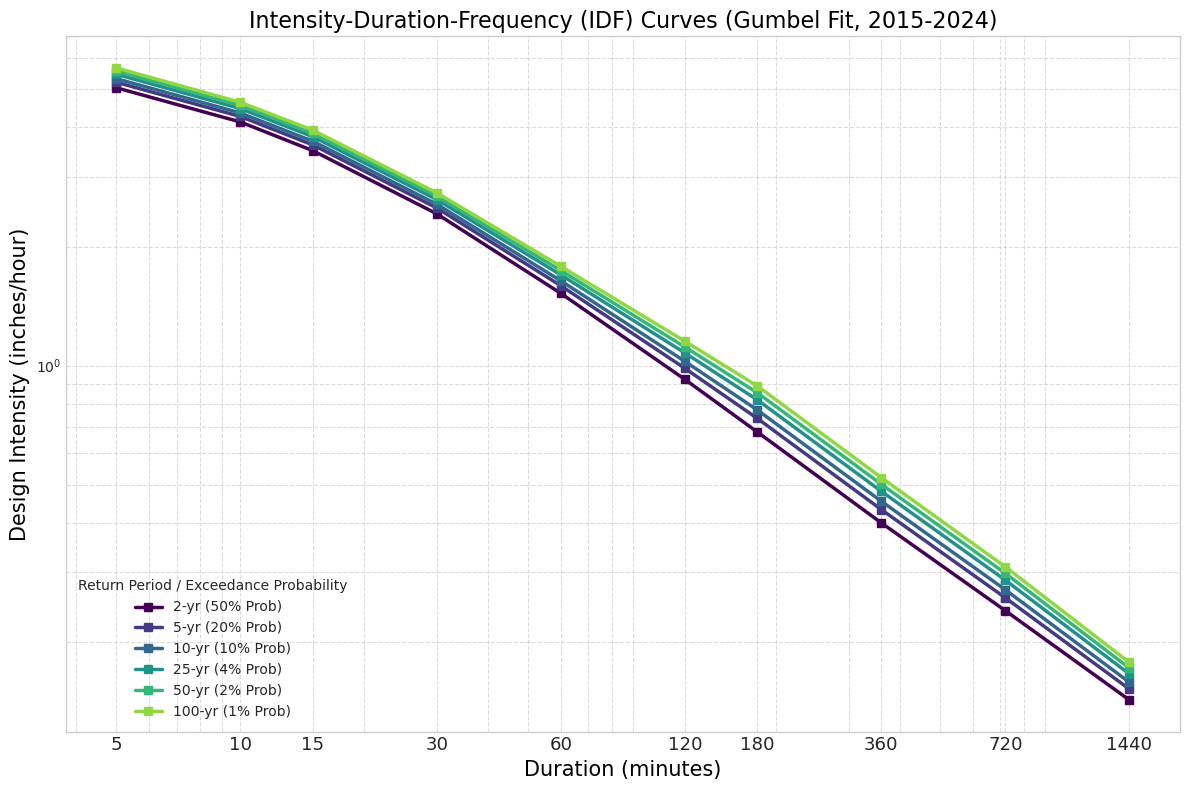

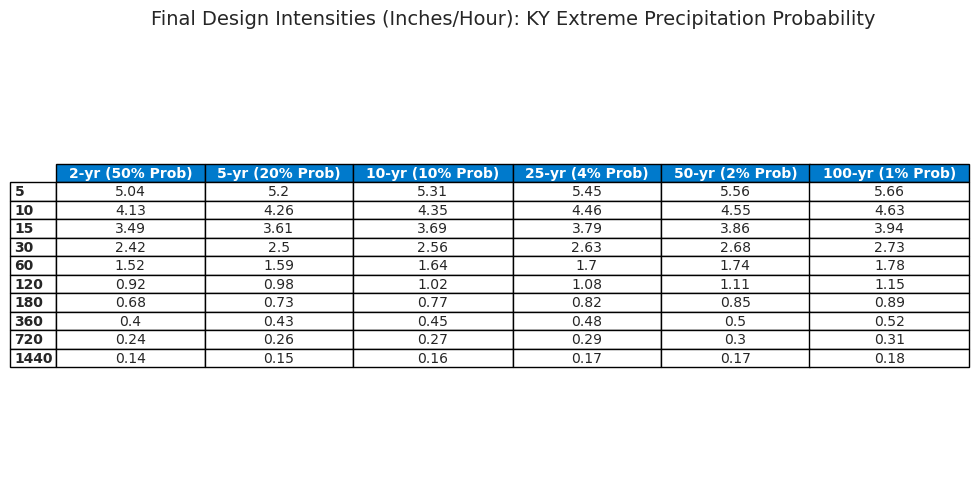

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from pathlib import Path

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
idf_plot_filename = 'final_atlas_14_style_idf_curve.png'
table_plot_filename = 'final_idf_results_table_v2.png' 

duration_minutes = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in duration_minutes]
return_periods = [2, 5, 10, 25, 50, 100]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print(f"Error: File not found at {annual_max_path}. Cannot proceed.")
    exit()

mean_annual_max_wide = annual_max_precip.groupby('year')[all_sum_cols].mean().reset_index()


#  Extreme Value Analysis (EVA) using Gumbel Distribution

idf_results = pd.DataFrame({'Duration_min': duration_minutes})

for T in return_periods:
    P = 1 / T
    F = 1 - P

    intensity_for_T = []
    
    for D_min, D_col in zip(duration_minutes, all_sum_cols):
        data_series = mean_annual_max_wide[D_col].dropna()
        
        if data_series.empty:
            intensity_for_T.append(np.nan)
            continue

        loc, scale = gumbel_r.fit(data_series)
        P_T = gumbel_r.ppf(F, loc=loc, scale=scale)
        I_T = (P_T / D_min) * 60 
        intensity_for_T.append(I_T)

    idf_results[f'{T}-yr ({int(P*100)}% Prob)'] = intensity_for_T

print("Extreme Value Analysis, IDF Results (Intensity in inches/hour):")
print(idf_results.to_string())


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

return_period_cols = idf_results.columns[1:]

for i, col in enumerate(return_period_cols):
    ax.plot(idf_results['Duration_min'], idf_results[col], 
            marker='s', linestyle='-', linewidth=2.5, 
            label=col, color=plt.cm.viridis(i/len(return_period_cols)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(duration_minutes)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.tick_params(axis='x', rotation=0, color='black', labelsize=13)

ax.set_title('Intensity-Duration-Frequency (IDF) Curves (Gumbel Fit, 2015-2024)', fontsize=16, color='black')
ax.set_xlabel('Duration (minutes)', fontsize=15, color='black')
ax.set_ylabel('Design Intensity (inches/hour)', fontsize=15, color='black')

ax.legend(title='Return Period / Exceedance Probability', loc='lower left')
ax.grid(which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(idf_plot_filename, dpi=500)

table_data = idf_results.copy()
table_data = table_data.set_index('Duration_min')
table_data.index.name = 'Duration (min)'
table_data = table_data.round(2)

fig_table, ax_table = plt.subplots(figsize=(10, len(table_data) * 0.5))
ax_table.axis('off') 

table = ax_table.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 rowLabels=table_data.index,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor("#007ACC")
        cell.set_text_props(color='white', fontweight='bold')
    if j == -1:
         cell.set_text_props(fontweight='bold')

ax_table.set_title('Final Design Intensities (Inches/Hour): KY Extreme Precipitation Probability',
             fontsize=14, pad=20)

fig_table.tight_layout()
plt.savefig(table_plot_filename, bbox_inches='tight', dpi=300)

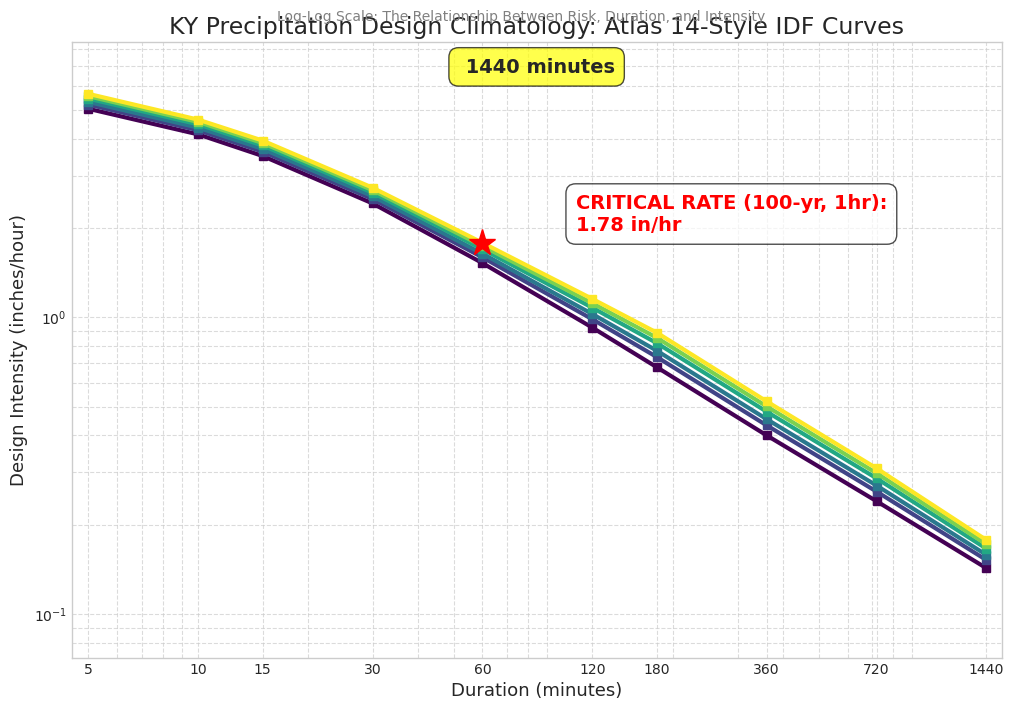

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import gumbel_r
from matplotlib.animation import FuncAnimation, FFMpegWriter
from pathlib import Path

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
video_filename = 'idf_curves_simultaneous_draw_final_scientific.mp4' 

duration_minutes = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in duration_minutes]
return_periods = [2, 5, 10, 25, 50, 100]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print(f"ERROR: File not found at {annual_max_path}. Cannot proceed without data.")
    exit()

mean_annual_max_wide = annual_max_precip.groupby('year')[all_sum_cols].mean().reset_index()
idf_results = pd.DataFrame({'Duration_min': duration_minutes})

for T in return_periods:
    P = 1 / T
    F = 1 - P
    intensity_for_T = []
    
    for D_min, D_col in zip(duration_minutes, all_sum_cols):
        data_series = mean_annual_max_wide[D_col].dropna()
        if len(data_series) < 5: 
            print(f"Warning: Duration {D_min}min has too few data points. Value set to NaN.")
            intensity_for_T.append(np.nan)
            continue
            
        loc, scale = gumbel_r.fit(data_series)
        P_T = gumbel_r.ppf(F, loc=loc, scale=scale)
        I_T = (P_T / D_min) * 60
        intensity_for_T.append(I_T)

    idf_results[f'{T}-yr ({int(P*100)}% Prob)'] = intensity_for_T



return_period_cols = [col for col in idf_results.columns if 'yr' in col]

max_intensity = idf_results[return_period_cols].max().max(skipna=True) * 1.5
min_intensity = idf_results[return_period_cols].min().min(skipna=True) * 0.5

if np.isnan(max_intensity) or max_intensity <= 0:
    print("\n[WARNING] Plot limits are invalid (e.g., all data is NaN). Setting generic limits.")
    max_intensity = 10.0 
    min_intensity = 0.1 

colors = plt.cm.viridis(np.linspace(0, 1, len(return_period_cols)))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(duration_minutes)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim([min_intensity, max_intensity])
ax.set_xlim([min(duration_minutes) * 0.9, max(duration_minutes) * 1.1])
ax.set_xlabel('Duration (minutes)', fontsize=13)
ax.set_ylabel('Design Intensity (inches/hour)', fontsize=13)
ax.grid(which='both', linestyle='--', alpha=0.7)

ax.set_title('KY Precipitation Design Climatology: Atlas 14-Style IDF Curves', fontsize=17)
fig.suptitle('Log-Log Scale: The Relationship Between Risk, Duration, and Intensity', 
             fontsize=10, y=0.92, color='gray')

lines = {}
for i, col in enumerate(return_period_cols):
    line, = ax.plot([], [], marker='s', linestyle='-', linewidth=3.0, 
                     label=col, color=colors[i])
    lines[col] = line

duration_annotation = ax.text(0.5, 0.95, '', transform=ax.transAxes, 
                     ha='center', fontsize=14, fontweight='bold', 
                     bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.7))

highlight_marker, = ax.plot([], [], marker='*', markersize=20, 
                            color='red', linestyle='None', zorder=20, alpha=0.0)
highlight_text = ax.text(0, 0, '', fontsize=14, fontweight='bold', color='red', zorder=20, alpha=0.0,
                         bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))

current_legend = ax.legend(title='Return Period / Exceedance Probability', loc='lower left')
current_legend.set_visible(False)


def update_plot(frame):
    if frame == 0:
        duration_annotation
        current_legend.set_visible(False)
        return list(lines.values()) + [duration_annotation, current_legend, highlight_marker, highlight_text]

    duration_index = frame - 1 
    x_data = idf_results['Duration_min'].iloc[:duration_index + 1]

    for col, line in lines.items():
        y_data = idf_results[col].iloc[:duration_index + 1]
        line.set_data(x_data, y_data)
        
    current_duration = duration_minutes[duration_index]
    duration_annotation.set_text(f' {current_duration} minutes')

    if frame > 0:
        current_legend.set_visible(True)

    if frame == len(duration_minutes):
        target_col = '100-yr (1% Prob)'
        target_duration = 60
        if target_col in idf_results.columns and target_duration in duration_minutes:
            duration_idx = duration_minutes.index(target_duration)
            x_highlight = idf_results['Duration_min'].iloc[duration_idx]
            y_highlight = idf_results[target_col].iloc[duration_idx]
            
            if not np.isnan(y_highlight):
                highlight_marker.set_data([x_highlight], [y_highlight])
                highlight_marker.set_alpha(1.0)
                
                highlight_text.set_position((x_highlight * 1.8, y_highlight * 1.1))
                highlight_text.set_text(f'CRITICAL RATE (100-yr, 1hr):\n{y_highlight:.2f} in/hr')
                highlight_text.set_alpha(1.0)
            
    return list(lines.values()) + [duration_annotation, current_legend, highlight_marker, highlight_text]

num_frames = len(duration_minutes) + 1 

try:
    writer = FFMpegWriter(fps=2.5, metadata=dict(artist='Me'), bitrate=2500)
    anim = FuncAnimation(fig, update_plot, frames=num_frames, interval=400, blit=False, repeat_delay=1000)
    
    anim.save(video_filename, writer=writer)

except Exception as e:
    print(f"\n[ERROR] Could not save video file directly. FFMpeg may not be installed or configured.")
    print(f"Details: {e}")

In [13]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# subplot with animation and spatial plot of rainfall maximum rainfall

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from scipy.interpolate import griddata 
from matplotlib.path import Path as MplPath 
import matplotlib.animation as animation 

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')

DURATION_CONFIGS = [
    {'col': 'sum_60min', 'label': '1-Hour'},
    {'col': 'sum_360min', 'label': '6-Hour'},
    {'col': 'sum_720min', 'label': '12-Hour'},
    {'col': 'sum_1440min', 'label': '24-Hour'},
]
YEARS_TO_PLOT = list(range(2015, 2025))

GIF_FILENAME = 'annual_amp_multi_duration_animation.gif'

station_coords = {
    'FCHV': {'latitude': 38.2050, 'longitude': -85.3400}, 'SCTV': {'latitude': 37.3197, 'longitude': -84.3497},
    'PCWN': {'latitude': 37.7347, 'longitude': -84.7700}, 'LGRN': {'latitude': 38.4556, 'longitude': -85.6439},
    'CHTR': {'latitude': 38.5833, 'longitude': -83.4253}, 'CADZ': {'latitude': 36.8533, 'longitude': -87.8106},
    'HCKM': {'latitude': 38.3117, 'longitude': -84.1450}, 'HRDB': {'latitude': 36.9633, 'longitude': -88.7511},
    'DORT': {'latitude': 37.3881, 'longitude': -82.4925}, 'WNCH': {'latitude': 37.9500, 'longitude': -84.2886},
    'DIXO': {'latitude': 37.5256, 'longitude': -87.7283}, 'BRND': {'latitude': 38.0058, 'longitude': -86.1656},
    'RPTN': {'latitude': 37.1989, 'longitude': -87.7317}, 'RSVL': {'latitude': 36.8647, 'longitude': -86.9147},
    'ELST': {'latitude': 37.6697, 'longitude': -84.2817}, 'WADD': {'latitude': 38.1650, 'longitude': -85.4217},
    'PSPG': {'latitude': 37.7711, 'longitude': -83.5681}, 'ZION': {'latitude': 36.7900, 'longitude': -87.3175},
    'FRNY': {'latitude': 37.8286, 'longitude': -87.9739}, 'PRYB': {'latitude': 37.1242, 'longitude': -83.5850},
    'GRHM': {'latitude': 38.9700, 'longitude': -84.7200}, 'CCLA': {'latitude': 37.8286, 'longitude': -85.9406},
    'CRMT': {'latitude': 37.8933, 'longitude': -85.6886}, 'SWZR': {'latitude': 36.6850, 'longitude': -86.5861},
    'BTCK': {'latitude': 37.9317, 'longitude': -82.9039}, 'MROK': {'latitude': 37.0700, 'longitude': -83.9117},
    'BLRK': {'latitude': 37.4725, 'longitude': -86.2081}, 'WDBY': {'latitude': 36.8375, 'longitude': -84.2258},
    'CRRL': {'latitude': 38.6925, 'longitude': -85.1383}, 'MRHD': {'latitude': 38.1569, 'longitude': -83.4792},
    'BMBL': {'latitude': 36.8833, 'longitude': -83.9189}, 'SWON': {'latitude': 38.5556, 'longitude': -84.7433},
    'ERLN': {'latitude': 37.1517, 'longitude': -87.5683}, 'HUEY': {'latitude': 38.4144, 'longitude': -85.3128},
    'VEST': {'latitude': 37.5847, 'longitude': -83.0850}, 'LUSA': {'latitude': 38.3853, 'longitude': -83.0039},
    'HHTS': {'latitude': 37.8500, 'longitude': -84.9967}, 'LXGN': {'latitude': 38.0317, 'longitude': -84.5517},
    'MQDY': {'latitude': 37.5300, 'longitude': -84.9669}, 'LSML': {'latitude': 38.1189, 'longitude': -85.7486},
    'WTBG': {'latitude': 36.7567, 'longitude': -84.3411}, 'QKSD': {'latitude': 38.3978, 'longitude': -85.0372},
    'PRST': {'latitude': 37.3878, 'longitude': -83.1708}, 'PGHL': {'latitude': 38.9950, 'longitude': -84.4100},
    'BNGL': {'latitude': 37.3325, 'longitude': -85.3400}, 'PVRT': {'latitude': 37.6683, 'longitude': -87.2714},
    'FARM': {'latitude': 36.9300, 'longitude': -86.4700}, 'HTFD': {'latitude': 37.4561, 'longitude': -86.9033},
    'OLIN': {'latitude': 37.7719, 'longitude': -86.5369}, 'RNDH': {'latitude': 37.6444, 'longitude': -85.3686},
    'ALBN': {'latitude': 36.6800, 'longitude': -85.1200}, 'LGNT': {'latitude': 37.5300, 'longitude': -85.2344},
    'RBSN': {'latitude': 37.4589, 'longitude': -83.3986}, 'HDYV': {'latitude': 36.7033, 'longitude': -83.5656},
    'HDGV': {'latitude': 38.0433, 'longitude': -85.9033}, 'FLRK': {'latitude': 36.6575, 'longitude': -84.4239},
    'GRDR': {'latitude': 37.2847, 'longitude': -83.8978}, 'CMBA': {'latitude': 37.1683, 'longitude': -85.0850},
    'DRFN': {'latitude': 36.7900, 'longitude': -88.4289}, 'BNVL': {'latitude': 37.5647, 'longitude': -83.7469},
    'BMTN': {'latitude': 36.8525, 'longitude': -83.2081}, 'WLBT': {'latitude': 38.8350, 'longitude': -83.9939},
    'MRRY': {'latitude': 36.5689, 'longitude': -88.3572}, 'PRNC': {'latitude': 37.1133, 'longitude': -87.9717},
    'WSHT': {'latitude': 37.6600, 'longitude': -85.8083}, 'LRTO': {'latitude': 37.5606, 'longitude': -84.9750},
    'CCTY': {'latitude': 37.2883, 'longitude': -87.1611},
}

key_cities = {
    'Louisville': (38.25, -85.76), 'Lexington': (38.00, -84.50),
    'Frankfort': (38.20, -84.87), 'Bowling Green': (36.98, -86.43) 
}

station_metadata = pd.DataFrame([
    {'station_id': sid, **coords} 
    for sid, coords in station_coords.items()
])

try:
    annual_max_precip = pd.read_csv(annual_max_path)
    
    duration_cols = [d['col'] for d in DURATION_CONFIGS]
    required_cols = ['station_id', 'year'] + duration_cols
    
    if not all(col in annual_max_precip.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in annual_max_precip.columns]
        print(f"Error: The precipitation file is missing one or more required columns: {missing_cols}.")
        exit()

    annual_data_subset = annual_max_precip[
        annual_max_precip['year'].isin(YEARS_TO_PLOT)
    ].copy()
    
    merged_data = pd.merge(
        annual_data_subset, 
        station_metadata[['station_id', 'latitude', 'longitude']], 
        on='station_id', 
        how='inner'
    ).dropna(subset=['latitude', 'longitude', 'year'] + duration_cols)

    if merged_data.empty:
        print("\nCRITICAL ERROR: The merged dataset is empty. Check station IDs and data structure.")
        exit()
    
except FileNotFoundError as e:
    print(f"Error: The required precipitation file was not found: {e.filename}. Cannot proceed.")
    exit()

min_lon, max_lon = -90.5, -81.5
min_lat, max_lat = 36.0, 39.5
GRID_RESOLUTION = 700 
lon_grid = np.linspace(min_lon, max_lon, GRID_RESOLUTION)
lat_grid = np.linspace(min_lat, max_lat, GRID_RESOLUTION)
xi, yi = np.meshgrid(lon_grid, lat_grid)

global_min = merged_data[duration_cols].min().min()
global_max = merged_data[duration_cols].max().max()
cmap = plt.cm.plasma 

print(f"DEBUG: Global AMP range for animation: {global_min:.2f} to {global_max:.2f} inches.")


def get_all_exterior_coords(geometry):
    if geometry.geom_type == 'Polygon':
        return [np.asarray(geometry.exterior.coords)]
    elif geometry.geom_type == 'MultiPolygon':
        coords = []
        for poly in geometry.geoms:
            coords.append(np.asarray(poly.exterior.coords))
        return coords
    return []

kentucky_geom = None
mask_2d = None
try:
    states_shp = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_1_states_provinces_lakes')
    states_reader = shpreader.Reader(states_shp)
    for state in states_reader.records():
        if state.attributes.get('name') == 'Kentucky':
            kentucky_geom = state.geometry
            break
    if kentucky_geom:
        exterior_coords_list = get_all_exterior_coords(kentucky_geom)
        grid_points = np.vstack((xi.flatten(), yi.flatten())).T

        final_mask = np.zeros(grid_points.shape[0], dtype=bool)
        for coords in exterior_coords_list:
            path = MplPath(coords)
            final_mask = final_mask | path.contains_points(grid_points)
        mask_2d = final_mask.reshape(xi.shape)
        print("DEBUG: Pre-calculated Kentucky mask.")
except Exception as e:
    print(f"CRITICAL MASKING ERROR: Could not extract Kentucky geometry. Error: {e}. Masking will be skipped.")
    kentucky_geom = None


plt.style.use('default') 
projection = ccrs.PlateCarree()

fig, axes_2d = plt.subplots(
    2, 2, 
    figsize=(15, 13),
    subplot_kw={'projection': projection}
)
axes = axes_2d.flatten() 

fig_title = fig.suptitle(
    f'Annual Maximum Precipitation for {YEARS_TO_PLOT[0]}', 
    fontsize=24, 
    fontweight='bold',y=0.8
)
fig.subplots_adjust(hspace=-0.5, wspace=0.03, top=0.84, bottom=0.08)

meshes = []
scatters = []

for j, ax in enumerate(axes):
    config = DURATION_CONFIGS[j]
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)
    ax.set_title(config['label'], fontsize=18, pad=5)

    ax.add_feature(cfeature.LAND, facecolor='white', alpha=1.0, zorder=0) 
    ax.add_feature(cfeature.OCEAN, facecolor='#e6f0ff', zorder=0) 
    ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='#0077b6', linewidth=0.3, zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='#00b4d8', alpha=0.5, zorder=1)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='gray', linewidth=0.3, zorder=2)

    if kentucky_geom:
        ax.add_geometries(
            [kentucky_geom], 
            ccrs.PlateCarree(),
            edgecolor='black', 
            facecolor='none', 
            linewidth=2.5, 
            zorder=8 
        )

    for city, (lat, lon) in key_cities.items():
        ax.plot(lon, lat, 'o', color='darkred', markersize=2, transform=projection, zorder=11)
        ax.annotate(city, (lon, lat), 
                    textcoords="offset points", xytext=(3,3), 
                    fontsize=8, color='darkred', fontweight='bold', 
                    transform=projection, zorder=11)

    year_0_data = merged_data[merged_data['year'] == YEARS_TO_PLOT[0]]
    points_0 = year_0_data[['longitude', 'latitude']].values
    values_0 = year_0_data[config['col']].values

    zi_0 = griddata(points_0, values_0, (xi, yi), method='cubic')
    nan_mask_0 = np.isnan(zi_0)
    if np.any(nan_mask_0):
         zi_0[nan_mask_0] = griddata(points_0, values_0, (xi[nan_mask_0], yi[nan_mask_0]), method='nearest')
    if mask_2d is not None:
        zi_0[~mask_2d] = np.nan

    mesh = ax.pcolormesh(
        lon_grid, lat_grid, zi_0,
        cmap=cmap, vmin=global_min, vmax=global_max,
        transform=projection, shading='auto', zorder=5 
    )
    meshes.append(mesh)

    scatter_plot = ax.scatter(
        year_0_data['longitude'], year_0_data['latitude'],
        c=values_0, s=30, alpha=0.9, cmap=cmap,
        vmin=global_min, vmax=global_max,
        edgecolor='black', linewidth=0.5, zorder=10, 
        transform=projection 
    )
    scatters.append(scatter_plot)

cbar_ax = fig.add_axes([0.93, 0.25, 0.03, 0.5])
fig.colorbar(meshes[0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel('Annual Maximum Precipitation (inches)', fontsize=16) 
cbar_ax.tick_params(labelsize=16)


def animate(i):
    year = YEARS_TO_PLOT[i]
    annual_data = merged_data[merged_data['year'] == year]

    fig_title.set_text(f'Annual Maximum Precipitation (AMP) for {year}')
    updated_artists = [fig_title]

    points = annual_data[['longitude', 'latitude']].values

    for j, config in enumerate(DURATION_CONFIGS):

        values = annual_data[config['col']].values

        zi = griddata(points, values, (xi, yi), method='cubic')
        nan_mask = np.isnan(zi)
        if np.any(nan_mask):
             zi[nan_mask] = griddata(points, values, (xi[nan_mask], yi[nan_mask]), method='nearest')

        if mask_2d is not None:
            zi[~mask_2d] = np.nan
            
        meshes[j].set_array(zi.ravel())
        
        scatters[j].set_array(values) 
        scatters[j].set_offsets(points)

        updated_artists.extend([meshes[j], scatters[j]])
    
    return updated_artists

print("Starting GIF generation (this may take a moment)...")

anim = animation.FuncAnimation(
    fig, 
    animate, 
    frames=len(YEARS_TO_PLOT), 
    interval=1000, 
    blit=False,     
    repeat_delay=2000 
)

anim.save(GIF_FILENAME, writer='pillow', fps=1.0) 

plt.close(fig)

print(f"\nSUCCESS: The animation has been saved to the file: {GIF_FILENAME}")
print("It loops through the annual maximum precipitation for 1-Hour, 6-Hour, 12-Hour, and 24-Hour durations for each year from 2015 to 2024.")


DEBUG: Global AMP range for animation: 0.00 to 11.28 inches.
DEBUG: Pre-calculated Kentucky mask.
Starting GIF generation (this may take a moment)...

SUCCESS: The animation has been saved to the file: annual_amp_multi_duration_animation.gif
It loops through the annual maximum precipitation for 1-Hour, 6-Hour, 12-Hour, and 24-Hour durations for each year from 2015 to 2024.


## VALIDATING FINDINGS OF THE IDF CURVE WITH ATLAS 14 

Extreme Value Analysis, IDF (Intensity in inches/hour)
   Duration_min  2-yr (50% Prob)  5-yr (20% Prob)  10-yr (10% Prob)  25-yr (4% Prob)  50-yr (2% Prob)  100-yr (1% Prob)
0             5         5.437754         6.395812          7.030130         7.831593         8.426164          9.016344
1            10         4.379077         4.900305          5.245402         5.681435         6.004908          6.325993
2            15         3.787250         4.442526          4.876375         5.424545         5.831209          6.234870
3            30         2.555077         2.929623          3.177605         3.490932         3.723375          3.954102
4            60         1.610225         1.837429          1.987857         2.177923         2.318926          2.458887
5           120         0.982166         1.129805          1.227555         1.351061         1.442686          1.533634
6           180         0.735275         0.884034          0.982526         1.106970         1.199290    

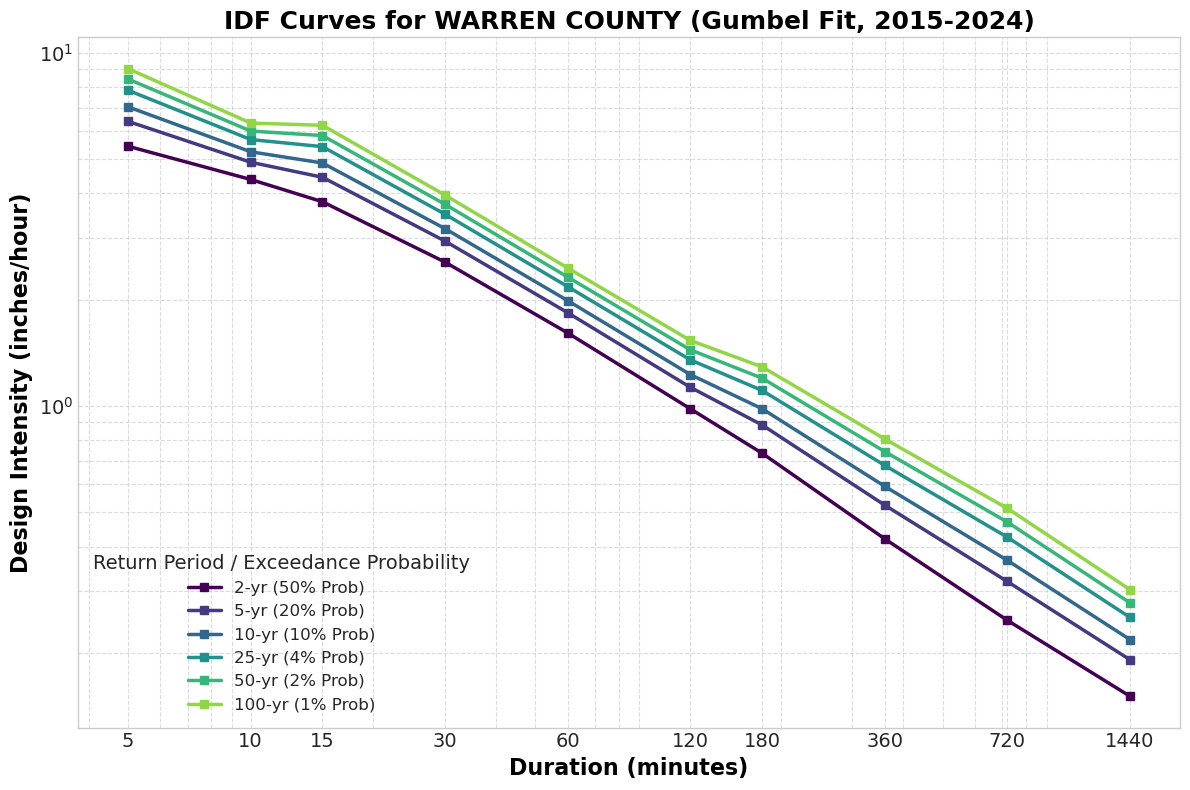

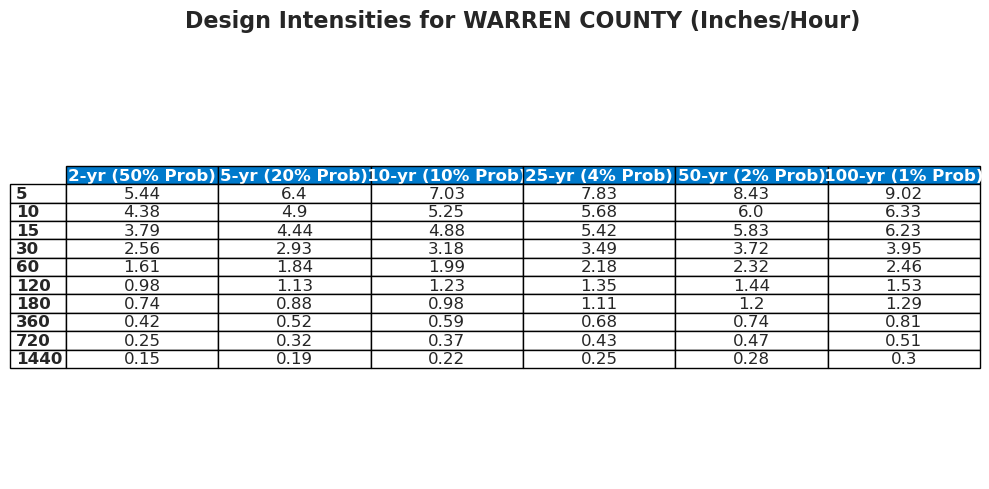

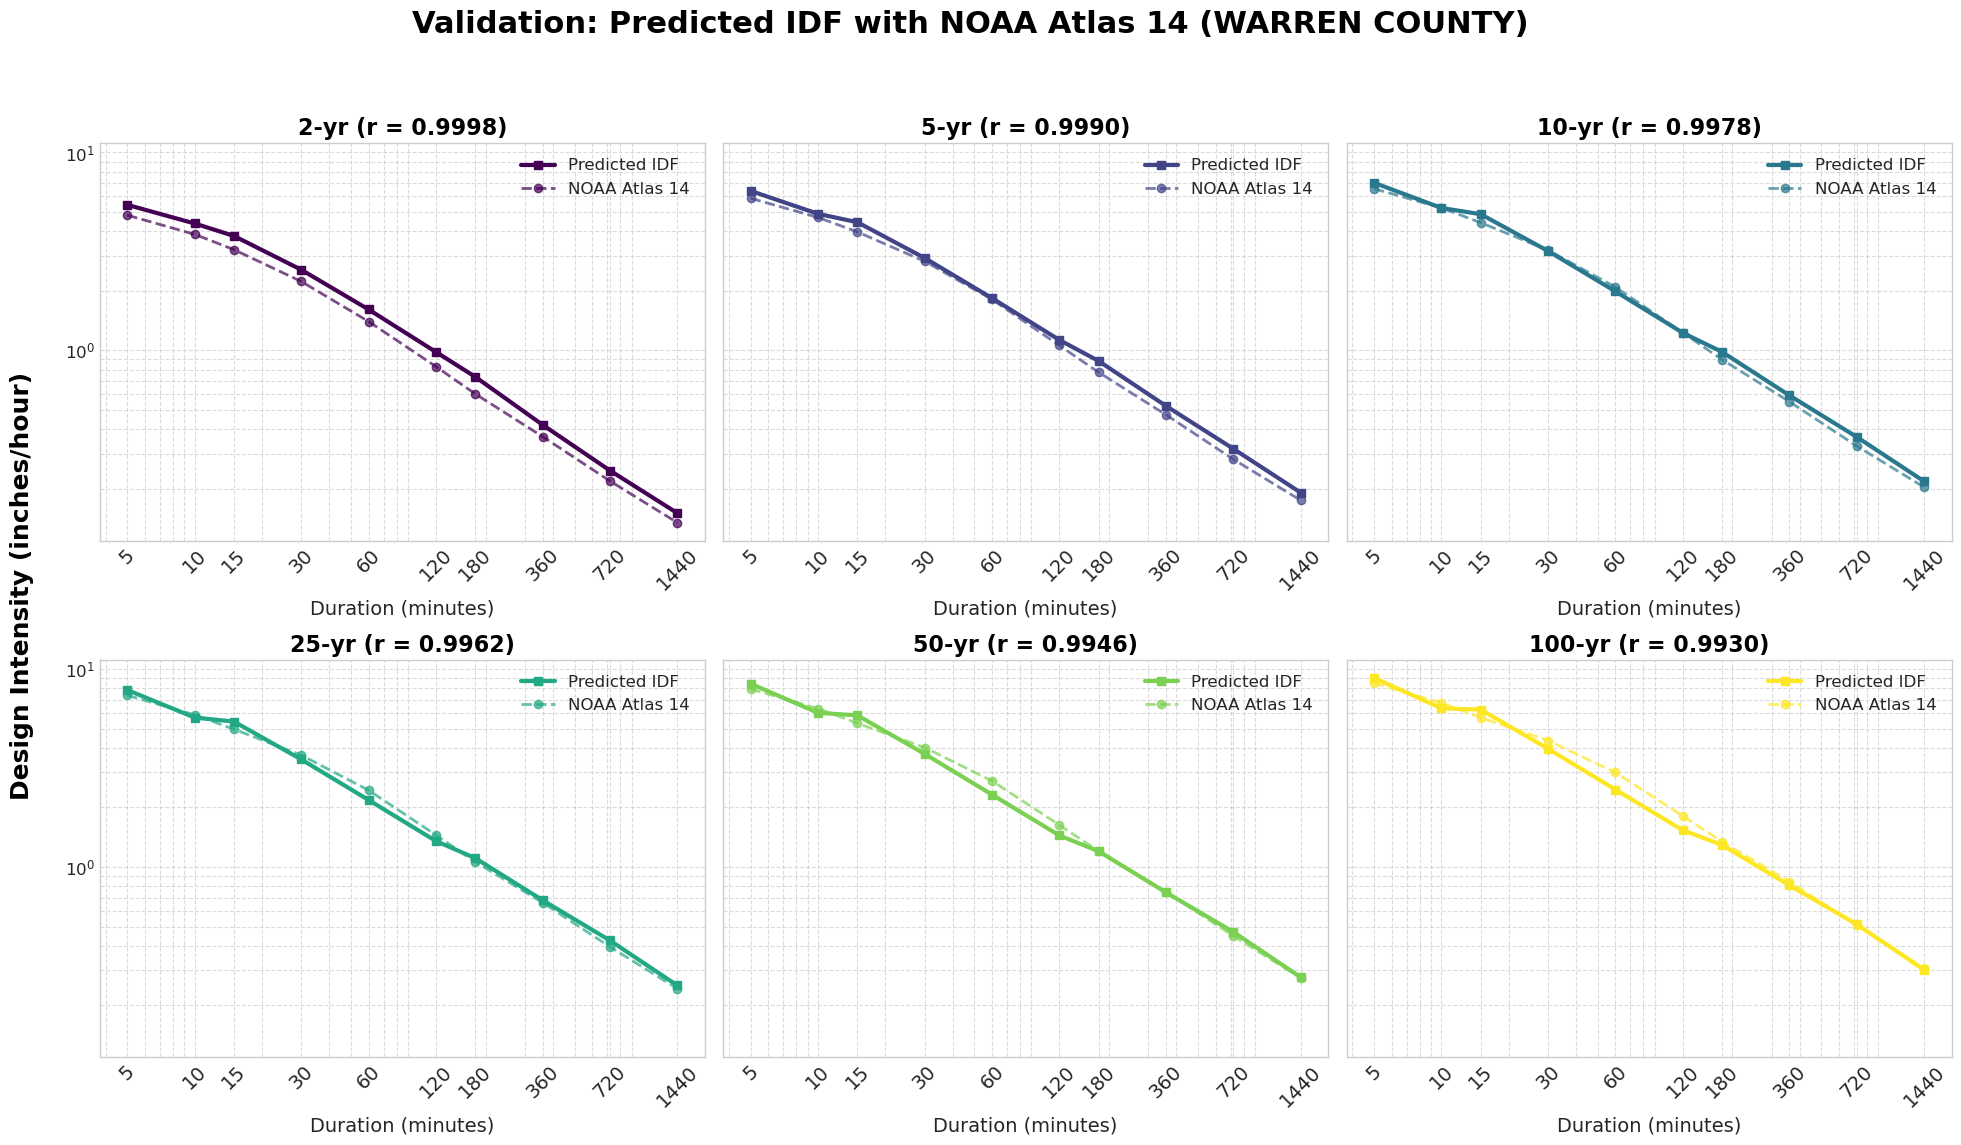

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from pathlib import Path
import numpy as np

annual_max_path = Path('/glade/u/home/npinkrah/hydroproject/annual_max_precip_2015_2024.csv')
station_id_to_analyze = 'FARM'

idf_plot_filename = f'{station_id_to_analyze}_final_idf_curve.png'
table_plot_filename = f'{station_id_to_analyze}_final_idf_results_table_v2.png'

comparison_plot_filename = f'{station_id_to_analyze}_idf_validation_comparison_subplots_corr.png'

duration_minutes = [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440]
all_sum_cols = [f'sum_{d}min' for d in duration_minutes]
return_periods = [2, 5, 10, 25, 50, 100]

try:
    annual_max_precip = pd.read_csv(annual_max_path)
except FileNotFoundError:
    print(f"Error: File not found at {annual_max_path}. Cannot proceed.")
    exit()

annual_max_precip_filtered = annual_max_precip[
    annual_max_precip['station_id'] == station_id_to_analyze
]

eva_data_df = annual_max_precip_filtered.groupby('year')[all_sum_cols].max().reset_index()

idf_results = pd.DataFrame({'Duration_min': duration_minutes})

for T in return_periods:
    P = 1 / T
    F = 1 - P

    intensity_for_T = []
    
    for D_min, D_col in zip(duration_minutes, all_sum_cols):
        data_series = eva_data_df[D_col].dropna() 
        
        if data_series.empty:
            intensity_for_T.append(np.nan)
            continue

        loc, scale = gumbel_r.fit(data_series)
        P_T = gumbel_r.ppf(F, loc=loc, scale=scale)
        I_T = (P_T / D_min) * 60 
        intensity_for_T.append(I_T)

    idf_results[f'{T}-yr ({int(P*100)}% Prob)'] = intensity_for_T

print("Extreme Value Analysis, IDF (Intensity in inches/hour)")
print(idf_results.to_string())

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

return_period_cols = idf_results.columns[1:]

for i, col in enumerate(return_period_cols):
    ax.plot(idf_results['Duration_min'], idf_results[col], 
             marker='s', linestyle='-', linewidth=2.5, 
             label=col, color=plt.cm.viridis(i/len(return_period_cols)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(duration_minutes)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.tick_params(axis='x', rotation=0, color='black', labelsize=14) 
ax.tick_params(axis='y', labelsize=14) 

ax.set_title(f'IDF Curves for WARREN COUNTY (Gumbel Fit, 2015-2024)', fontsize=18, color='black', fontweight='bold') 
ax.set_xlabel('Duration (minutes)', fontsize=16, color='black', fontweight='bold') 
ax.set_ylabel('Design Intensity (inches/hour)', fontsize=16, color='black', fontweight='bold') 

ax.legend(title='Return Period / Exceedance Probability', loc='lower left', fontsize=12, title_fontsize=14) 
ax.grid(which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(idf_plot_filename, dpi=500)

table_data = idf_results.copy()
table_data = table_data.set_index('Duration_min')
table_data.index.name = 'Duration (min)'
table_data = table_data.round(2)

fig_table, ax_table = plt.subplots(figsize=(10, len(table_data) * 0.5))
ax_table.axis('off') 

table = ax_table.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     rowLabels=table_data.index,
                     cellLoc='center',
                     loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12) 

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor("#007ACC")
        cell.set_text_props(color='white', fontweight='bold')
    if j == -1:
        cell.set_text_props(fontweight='bold')

ax_table.set_title(f'Design Intensities for WARREN COUNTY (Inches/Hour)',
             fontsize=16, pad=20, fontweight='bold') 

fig_table.tight_layout()
plt.savefig(table_plot_filename, bbox_inches='tight', dpi=300)

atlas_14_data = {
    'Duration_str': ['5-min', '10-min', '15-min', '30-min', '60-min', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr'],
    'Duration_min': [5, 10, 15, 30, 60, 120, 180, 360, 720, 1440],
    '2-yr (50% Prob)': [4.82, 3.86, 3.23, 2.23, 1.40, 0.829, 0.603, 0.367, 0.219, 0.135],
    '5-yr (20% Prob)': [5.87, 4.70, 3.97, 2.82, 1.81, 1.06, 0.775, 0.473, 0.282, 0.175],
    '10-yr (10% Prob)': [6.56, 5.25, 4.42, 3.21, 2.09, 1.23, 0.899, 0.551, 0.329, 0.204],
    '25-yr (4% Prob)': [7.36, 5.87, 4.96, 3.67, 2.44, 1.45, 1.06, 0.660, 0.395, 0.243],
    '50-yr (2% Prob)': [7.92, 6.31, 5.32, 4.01, 2.72, 1.63, 1.20, 0.748, 0.448, 0.275],
    '100-yr (1% Prob)': [8.48, 6.74, 5.68, 4.35, 3.00, 1.81, 1.34, 0.844, 0.507, 0.308]
}
atlas_df = pd.DataFrame(atlas_14_data).drop(columns=['Duration_str'])

rp_cols = [col for col in idf_results.columns if 'yr' in col]
num_subplots = len(rp_cols)
n_cols = 3
n_rows = int(np.ceil(num_subplots / n_cols))

fig_comp, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=False, sharey=True)
axes = axes.flatten()

fig_comp.text(0.02, 0.5, 'Design Intensity (inches/hour)', 
              va='center', rotation='vertical', fontsize=18, color='black', fontweight='bold')

colors = plt.cm.viridis(np.linspace(0, 1, num_subplots))

for i, col in enumerate(rp_cols):
    ax = axes[i]
    color = colors[i] 

    y_true = atlas_df[col] 
    y_pred = idf_results[col]
    comparison_df = pd.DataFrame({'True': y_true, 'Predicted': y_pred}).dropna()
    
    correlation_r = np.nan
    if len(comparison_df) > 1: 
        correlation_r = np.corrcoef(comparison_df['True'], comparison_df['Predicted'])[0, 1]

    ax.plot(idf_results['Duration_min'], idf_results[col], 
             marker='s', linestyle='-', linewidth=3.0, 
             label=f'Predicted IDF', 
             color=color)

    ax.plot(atlas_df['Duration_min'], atlas_df[col], 
             marker='o', linestyle='--', linewidth=2.0, 
             label=f'NOAA Atlas 14', 
             color=color, alpha=0.7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(duration_minutes)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    
    ax.set_xlabel('Duration (minutes)', fontsize=14)
    
    ax.tick_params(axis='x', rotation=45, color='black', labelsize=14, width='bold') 
    ax.tick_params(axis='y', labelsize=12) 

    r_str = f"r = {correlation_r:.4f}" if not np.isnan(correlation_r) else "r = N/A"

    ax.set_title(f"{col.split(' ')[0]} ({r_str})", fontsize=16, color='black', fontweight='bold') 
    
    ax.legend(loc='best', fontsize=12) 
    ax.grid(which='both', linestyle='--', alpha=0.7)

for i in range(num_subplots, len(axes)):
    fig_comp.delaxes(axes[i])

fig_comp.suptitle(f'Validation: Predicted IDF with NOAA Atlas 14 (WARREN COUNTY)', 
                  fontsize=22, color='black', fontweight='bold', y=0.98) 

plt.tight_layout(rect=[0.04, 0.03, 1, 0.94]) 
plt.savefig(comparison_plot_filename, dpi=500) 

In [5]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
